In [1]:
import gym
import time
from tqdm import tqdm
import random
import os
import matplotlib.pyplot as plt

import numpy as np
import time
import torch as T
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.distributions import MultivariateNormal

Fix environment

In [2]:
seed = 666 # Do not change this
device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
def fix(env, seed):
    env.seed(seed)
    env.action_space.seed(seed)
    T.manual_seed(seed)
    T.cuda.manual_seed(seed)
    T.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
  #torch.set_deterministic(True)
    T.backends.cudnn.benchmark = False
    T.backends.cudnn.deterministic = True

Construct the (linear) network structure--

In [3]:
class FeedForwardNN(nn.Module):
    def __init__(self, in_dim, out_dim, name, chkpt_dir):
        super(FeedForwardNN, self).__init__()
    
        self.chkpt_file = os.path.join(chkpt_dir, name)
    
        self.layer1 = nn.Linear(in_dim, 64)
        self.layer2 = nn.Linear(64, 64)
        self.layer3 = nn.Linear(64, out_dim)
    
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
    
        self.to(self.device)
    
    def forward(self, obs):
        x = F.relu(self.layer1(obs))
        x = F.relu(self.layer2(x))
        output = self.layer3(x)
        return output

    def save_checkpoint(self):
        T.save(self.state_dict(), self.chkpt_file)

    def load_checkpoint(self):
        self.load_state_dict(T.load(self.chkpt_file))

Create buffer

Construct our PPO class (which is also our agent) --

In [4]:
class PPO:
    def __init__(self, network, obs_dim, act_dim, subgaussian = False,delta = 2, lr = 0.005, gamma = 0.99, clip = 0.2, n_updates_per_iteration = 5, \
                max_timesteps_per_episode = 200, timesteps_per_batch = 2048, chkpt_dir = 'model/'):
        self.chkpt_dir = chkpt_dir
        
        self.timesteps_per_batch = timesteps_per_batch                 # Number of timesteps to run per batch
        self.max_timesteps_per_episode = max_timesteps_per_episode          # Max number of timesteps per episode
        self.n_updates_per_iteration = n_updates_per_iteration                # Number of times to update actor/critic per iteration
        self.lr = lr                                 # Learning rate of actor optimizer
        self.gamma = gamma                               # Discount factor to be applied when calculating Rewards-To-Go
        self.clip = clip                                 # Recommended 0.2, helps define the threshold to clip the ratio during SGA
        
        self.obs_dim = obs_dim
        self.act_dim = act_dim
        
        self.subgaussian = subgaussian
        self.delta = delta
        
        name = '.pth'
        if subgaussian:
            name = '_subgaussian.pth'
        
        self.actor = network(self.obs_dim, self.act_dim, 'ppo_actor'+name, self.chkpt_dir) 
        self.critic = network(self.obs_dim, 1, 'ppo_critic'+name, self.chkpt_dir)
        
        # Initialize optimizers for actor and critic
        self.actor_optim = Adam(self.actor.parameters(), lr=self.lr)
        self.critic_optim = Adam(self.critic.parameters(), lr=self.lr)
        
        # Initialize the covariance matrix used to query the actor for actions
        self.cov_var = T.full(size=(self.act_dim,), fill_value=0.5)
        self.cov_mat = T.diag(self.cov_var)
        
    def learn(self, batch_obs, batch_acts, batch_rews, batch_log_probs):
        
        device = self.actor.device
        
        batch_rtgs = self.compute_rtgs(batch_rews)
        batch_rtgs = T.tensor(np.array(batch_rtgs), dtype=T.float).to(device)
        batch_obs = T.tensor(np.array(batch_obs), dtype=T.float).to(device)
        batch_acts = T.tensor(np.array(batch_acts), dtype=T.float).to(device)
        batch_log_probs = T.tensor(np.array(batch_log_probs), dtype=T.float).to(device)
        
        # Calculate advantage at k-th iteration
        V, _ = self.evaluate(batch_obs, batch_acts)
        A_k = batch_rtgs - V.detach()          
        A_k = (A_k - A_k.mean()) / (A_k.std() + 1e-10) # Normalizing the advantage
        
        for _ in range(self.n_updates_per_iteration):
            V, curr_log_probs = self.evaluate(batch_obs, batch_acts)
            
            ratios = T.exp(curr_log_probs - batch_log_probs)
            if self.subgaussian:
                var = T.exp(curr_log_probs - batch_log_probs).var()
                var_1 = var.sqrt() * self.delta
                ratios = T.div(ratios, 1-var_1 + var_1 * ratios)
                
            
            # Calculate surrogate losses.
            surr1 = ratios * A_k
            surr2 = T.clamp(ratios, 1 - self.clip, 1 + self.clip) * A_k
            
            actor_loss = (-T.min(surr1, surr2)).mean()
            critic_loss = nn.MSELoss()(V, batch_rtgs)
            
            # Calculate gradients and perform backward propagation for actor network
            self.actor_optim.zero_grad()
            actor_loss.backward(retain_graph=True)
            self.actor_optim.step()
            
            # Calculate gradients and perform backward propagation for critic network
            self.critic_optim.zero_grad()
            critic_loss.backward()
            self.critic_optim.step()    
            
    def compute_rtgs(self, batch_rews):
        batch_rtgs = []
        
        for epoch_rews in reversed(batch_rews):
            discounted_reward = 0
            for rew in reversed(epoch_rews):
                discounted_reward = rew + discounted_reward * self.gamma
                batch_rtgs.insert(0, discounted_reward)
                
        
        return batch_rtgs
        
    def get_action(self, obs):
        state = T.tensor(obs, dtype=T.float).to(self.actor.device)
        mean = self.actor.forward(state)
        
        distr = MultivariateNormal(mean, self.cov_mat)
        action = distr.sample()
        log_prob = distr.log_prob(action)
        return action.detach().cpu().numpy(), log_prob.detach().cpu().numpy()
    
        
    def evaluate(self, batch_obs, batch_acts):
        # Estimate the values of each observation, and the log probs of
        # each action in the most recent batch with the most recent
        # iteration of the actor network. Should be called from learn.
        
        # Query critic network for a value V for each batch_obs. Shape of V should be same as batch_rtgs
        V = self.critic.forward(batch_obs).squeeze()
        
        # Calculate the log probabilities of batch actions using most recent actor network.
        mean = self.actor.forward(batch_obs)
        dist = MultivariateNormal(mean, self.cov_mat)
        log_probs = dist.log_prob(batch_acts)

        # V - the predicted values of batch_obs
        # log_probs - the log probabilities of the actions taken in batch_acts given batch_obs
        return V, log_probs
    
    def save_checkpoint():
        self.actor.save_checkpoint()
        self.critic.save_checkpoint()
    
    def load_checkpoint():
        self.actor.load_checkpoint()
        self.critic.load_checkpoint()
        

Define the function to collect the on-policy trajectories--

In [5]:
def rollout(policy, env, timesteps_per_batch, max_timesteps_per_episode):
    # Batch data.
    batch_obs = []
    batch_acts = []
    batch_log_probs = []
    batch_rews = []
    batch_lens = []
    
    epoch_rews = []
    t=0
    while t < timesteps_per_batch:
        epoch_rews = [] # rewards collected per episode
        obs = env.reset()
        done = False
        for h in range(max_timesteps_per_episode):
            batch_obs.append(obs)
            action, log_prob = policy.get_action(obs)
            obs, rew, done, _ = env.step(action)
            t +=1
            
            epoch_rews.append(rew)
            batch_acts.append(action)
            batch_log_probs.append(log_prob)
            
            if done:
                break
            
        batch_lens.append(h+1)
        batch_rews.append(epoch_rews)
    
    
    
    return batch_obs, batch_acts, batch_rews, batch_log_probs, batch_lens

In [6]:
hyperparameters = {
    'timesteps_per_batch': 2048, 
    'max_timesteps_per_episode': 200, 
    'gamma': 0.99, 
    'n_updates_per_iteration': 10,
    'lr': 3e-4, 
    'clip': 0.2,
    'seed': 666
    }

The training loop----

In [8]:
env = gym.make('Pendulum-v0')
fix(env, seed)
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.shape[0]

ITERATIONS = 2000

Train (vanilla importance sampling)--

In [12]:
ITERATIONS = 300
model = PPO(network=FeedForwardNN, obs_dim = obs_dim, act_dim = act_dim, subgaussian = False)
#model.load_checkpoint()
#model.critic.load_checkpoint()
model.actor.train()
model.critic.train()


tmp = 0.0

avg_ep_rews_log = []

prg_bar = tqdm(range(ITERATIONS))
for i in prg_bar:
    batch_obs, batch_acts, batch_rews, batch_log_probs, batch_lens = \
        rollout(model, env, hyperparameters['timesteps_per_batch'], hyperparameters['max_timesteps_per_episode'])

    avg_ep_lens = np.mean(batch_lens)
    avg_ep_rews = np.mean([np.sum(ep_rews) for ep_rews in batch_rews])
    avg_ep_rews_log.append(avg_ep_rews)
    
    # Round decimal places for more aesthetic logging messages
    avg_ep_lens = str(round(avg_ep_lens, 2))
    avg_ep_rews_1 = str(round(avg_ep_rews, 2))

    print(f"-------------------- Iteration --------------------", flush=True)
    print(f"Average Episodic Length: {avg_ep_lens}", flush=True)
    print(f"Average Episodic Return: {avg_ep_rews_1}", flush=True)
    
    model.learn(batch_obs, batch_acts, batch_rews, batch_log_probs)
    if avg_ep_rews > tmp:
        model.actor.save_checkpoint()
        model.critic.save_checkpoint()
        print("Successfully save the model!",flush=True)
    tmp = avg_ep_rews
    

  0%|                                                                                          | 0/300 [00:00<?, ?it/s]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1205.12


  0%|▎                                                                                 | 1/300 [00:02<09:58,  2.00s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1382.47


  1%|▌                                                                                 | 2/300 [00:04<09:57,  2.01s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1157.71
Successfully save the model!


  1%|▊                                                                                 | 3/300 [00:05<09:40,  1.96s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1123.34
Successfully save the model!


  1%|█                                                                                 | 4/300 [00:07<09:45,  1.98s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1207.63


  2%|█▎                                                                                | 5/300 [00:09<09:36,  1.95s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1323.1


  2%|█▋                                                                                | 6/300 [00:11<09:23,  1.92s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1491.8


  2%|█▉                                                                                | 7/300 [00:13<09:53,  2.02s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1382.22
Successfully save the model!


  3%|██▏                                                                               | 8/300 [00:16<10:38,  2.19s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1237.11
Successfully save the model!


  3%|██▍                                                                               | 9/300 [00:18<10:37,  2.19s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1369.59


  3%|██▋                                                                              | 10/300 [00:20<10:09,  2.10s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1025.82
Successfully save the model!


  4%|██▉                                                                              | 11/300 [00:22<10:02,  2.09s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1311.05


  4%|███▏                                                                             | 12/300 [00:25<10:40,  2.22s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1243.55
Successfully save the model!


  4%|███▌                                                                             | 13/300 [00:27<10:23,  2.17s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1206.53
Successfully save the model!


  5%|███▊                                                                             | 14/300 [00:29<10:15,  2.15s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1136.0
Successfully save the model!


  5%|████                                                                             | 15/300 [00:31<10:14,  2.15s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1173.97


  5%|████▎                                                                            | 16/300 [00:33<10:41,  2.26s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1243.29


  6%|████▌                                                                            | 17/300 [00:36<10:32,  2.23s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1152.24
Successfully save the model!


  6%|████▊                                                                            | 18/300 [00:38<10:08,  2.16s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1155.47


  6%|█████▏                                                                           | 19/300 [00:40<10:07,  2.16s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1255.12


  7%|█████▍                                                                           | 20/300 [00:43<11:18,  2.42s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1251.51
Successfully save the model!


  7%|█████▋                                                                           | 21/300 [00:45<10:45,  2.31s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1342.5


  7%|█████▉                                                                           | 22/300 [00:47<10:30,  2.27s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1299.6
Successfully save the model!


  8%|██████▏                                                                          | 23/300 [00:49<10:29,  2.27s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1266.03
Successfully save the model!


  8%|██████▍                                                                          | 24/300 [00:52<10:32,  2.29s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1120.45
Successfully save the model!


  8%|██████▊                                                                          | 25/300 [00:54<10:13,  2.23s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1148.24


  9%|███████                                                                          | 26/300 [00:56<09:47,  2.15s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1141.95
Successfully save the model!


  9%|███████▎                                                                         | 27/300 [00:58<09:32,  2.10s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1124.33
Successfully save the model!


  9%|███████▌                                                                         | 28/300 [01:00<09:26,  2.08s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1145.39


 10%|███████▊                                                                         | 29/300 [01:02<09:37,  2.13s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1294.16


 10%|████████                                                                         | 30/300 [01:04<09:35,  2.13s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1015.12
Successfully save the model!


 10%|████████▎                                                                        | 31/300 [01:06<09:27,  2.11s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1152.5


 11%|████████▋                                                                        | 32/300 [01:08<09:16,  2.08s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1206.88


 11%|████████▉                                                                        | 33/300 [01:10<09:17,  2.09s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1074.1
Successfully save the model!


 11%|█████████▏                                                                       | 34/300 [01:12<08:52,  2.00s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1106.15


 12%|█████████▍                                                                       | 35/300 [01:14<08:59,  2.04s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1289.43


 12%|█████████▋                                                                       | 36/300 [01:16<08:45,  1.99s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1052.72
Successfully save the model!


 12%|█████████▉                                                                       | 37/300 [01:18<08:49,  2.01s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1118.64


 13%|██████████▎                                                                      | 38/300 [01:20<08:28,  1.94s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1119.17


 13%|██████████▌                                                                      | 39/300 [01:22<08:15,  1.90s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1109.02
Successfully save the model!


 13%|██████████▊                                                                      | 40/300 [01:24<08:12,  1.89s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1113.01


 14%|███████████                                                                      | 41/300 [01:25<08:09,  1.89s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1170.23


 14%|███████████▎                                                                     | 42/300 [01:27<08:07,  1.89s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1296.46


 14%|███████████▌                                                                     | 43/300 [01:29<08:04,  1.88s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1212.1
Successfully save the model!


 15%|███████████▉                                                                     | 44/300 [01:31<07:53,  1.85s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1068.94
Successfully save the model!


 15%|████████████▏                                                                    | 45/300 [01:33<07:50,  1.84s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1236.96


 15%|████████████▍                                                                    | 46/300 [01:35<07:57,  1.88s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1036.13
Successfully save the model!


 16%|████████████▋                                                                    | 47/300 [01:37<08:24,  1.99s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1125.14


 16%|████████████▉                                                                    | 48/300 [01:39<08:37,  2.06s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1200.86


 16%|█████████████▏                                                                   | 49/300 [01:41<08:42,  2.08s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1245.24


 17%|█████████████▌                                                                   | 50/300 [01:43<08:14,  1.98s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1058.68
Successfully save the model!


 17%|█████████████▊                                                                   | 51/300 [01:45<07:55,  1.91s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1087.56


 17%|██████████████                                                                   | 52/300 [01:47<08:24,  2.03s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1093.75


 18%|██████████████▎                                                                  | 53/300 [01:49<08:30,  2.07s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1041.55
Successfully save the model!


 18%|██████████████▌                                                                  | 54/300 [01:51<08:11,  2.00s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1036.38
Successfully save the model!


 18%|██████████████▊                                                                  | 55/300 [01:53<07:57,  1.95s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -996.66
Successfully save the model!


 19%|███████████████                                                                  | 56/300 [01:55<07:46,  1.91s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1072.69


 19%|███████████████▍                                                                 | 57/300 [01:57<08:00,  1.98s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1056.06
Successfully save the model!


 19%|███████████████▋                                                                 | 58/300 [01:59<07:54,  1.96s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1130.26


 20%|███████████████▉                                                                 | 59/300 [02:01<07:41,  1.91s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1090.2
Successfully save the model!


 20%|████████████████▏                                                                | 60/300 [02:03<08:06,  2.03s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1095.62


 20%|████████████████▍                                                                | 61/300 [02:05<08:03,  2.02s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1121.54


 21%|████████████████▋                                                                | 62/300 [02:07<08:06,  2.05s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -982.06
Successfully save the model!


 21%|█████████████████                                                                | 63/300 [02:09<08:15,  2.09s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1053.02


 21%|█████████████████▎                                                               | 64/300 [02:11<08:01,  2.04s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1001.53
Successfully save the model!


 22%|█████████████████▌                                                               | 65/300 [02:13<07:50,  2.00s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -991.57
Successfully save the model!


 22%|█████████████████▊                                                               | 66/300 [02:15<07:51,  2.02s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1034.52


 22%|██████████████████                                                               | 67/300 [02:17<07:54,  2.04s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1019.77
Successfully save the model!


 23%|██████████████████▎                                                              | 68/300 [02:19<07:54,  2.05s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1053.69


 23%|██████████████████▋                                                              | 69/300 [02:21<07:46,  2.02s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1025.33
Successfully save the model!


 23%|██████████████████▉                                                              | 70/300 [02:23<07:41,  2.01s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -952.08
Successfully save the model!


 24%|███████████████████▏                                                             | 71/300 [02:25<07:46,  2.04s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -966.86


 24%|███████████████████▍                                                             | 72/300 [02:27<07:27,  1.96s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1030.45


 24%|███████████████████▋                                                             | 73/300 [02:29<07:13,  1.91s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1007.94
Successfully save the model!


 25%|███████████████████▉                                                             | 74/300 [02:31<07:02,  1.87s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -901.24
Successfully save the model!


 25%|████████████████████▎                                                            | 75/300 [02:33<06:59,  1.86s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -982.53


 25%|████████████████████▌                                                            | 76/300 [02:34<06:52,  1.84s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -987.13


 26%|████████████████████▊                                                            | 77/300 [02:36<06:50,  1.84s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -927.44
Successfully save the model!


 26%|█████████████████████                                                            | 78/300 [02:38<06:47,  1.83s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1034.01


 26%|█████████████████████▎                                                           | 79/300 [02:40<06:41,  1.82s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1066.2


 27%|█████████████████████▌                                                           | 80/300 [02:42<06:38,  1.81s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -971.87
Successfully save the model!


 27%|█████████████████████▊                                                           | 81/300 [02:43<06:34,  1.80s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -906.31
Successfully save the model!


 27%|██████████████████████▏                                                          | 82/300 [02:45<06:29,  1.79s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -996.17


 28%|██████████████████████▍                                                          | 83/300 [02:47<06:33,  1.81s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1066.01


 28%|██████████████████████▋                                                          | 84/300 [02:49<06:31,  1.81s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1068.26


 28%|██████████████████████▉                                                          | 85/300 [02:51<06:27,  1.80s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -971.22
Successfully save the model!


 29%|███████████████████████▏                                                         | 86/300 [02:52<06:23,  1.79s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1017.19


 29%|███████████████████████▍                                                         | 87/300 [02:54<06:17,  1.77s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -993.84
Successfully save the model!


 29%|███████████████████████▊                                                         | 88/300 [02:56<06:17,  1.78s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -990.8
Successfully save the model!


 30%|████████████████████████                                                         | 89/300 [02:58<06:16,  1.78s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -905.16
Successfully save the model!


 30%|████████████████████████▎                                                        | 90/300 [02:59<06:13,  1.78s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -955.93


 30%|████████████████████████▌                                                        | 91/300 [03:01<06:20,  1.82s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -911.03
Successfully save the model!


 31%|████████████████████████▊                                                        | 92/300 [03:03<06:07,  1.76s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -977.36


 31%|█████████████████████████                                                        | 93/300 [03:05<06:04,  1.76s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -913.92
Successfully save the model!


 31%|█████████████████████████▍                                                       | 94/300 [03:06<05:59,  1.75s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -859.07
Successfully save the model!


 32%|█████████████████████████▋                                                       | 95/300 [03:08<05:58,  1.75s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -893.15


 32%|█████████████████████████▉                                                       | 96/300 [03:10<05:56,  1.75s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -902.33


 32%|██████████████████████████▏                                                      | 97/300 [03:12<05:58,  1.76s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -968.77


 33%|██████████████████████████▍                                                      | 98/300 [03:14<05:54,  1.75s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -942.43
Successfully save the model!


 33%|██████████████████████████▋                                                      | 99/300 [03:15<05:53,  1.76s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -914.03
Successfully save the model!


 33%|██████████████████████████▋                                                     | 100/300 [03:17<06:19,  1.90s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -877.88
Successfully save the model!


 34%|██████████████████████████▉                                                     | 101/300 [03:19<06:20,  1.91s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -895.69


 34%|███████████████████████████▏                                                    | 102/300 [03:21<06:15,  1.89s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -899.25


 34%|███████████████████████████▍                                                    | 103/300 [03:23<06:06,  1.86s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -939.16


 35%|███████████████████████████▋                                                    | 104/300 [03:25<05:56,  1.82s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -964.36


 35%|████████████████████████████                                                    | 105/300 [03:27<05:53,  1.81s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -984.37


 35%|████████████████████████████▎                                                   | 106/300 [03:28<05:50,  1.81s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -962.37
Successfully save the model!


 36%|████████████████████████████▌                                                   | 107/300 [03:30<05:46,  1.79s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -895.41
Successfully save the model!


 36%|████████████████████████████▊                                                   | 108/300 [03:32<05:44,  1.80s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -900.61


 36%|█████████████████████████████                                                   | 109/300 [03:34<05:38,  1.77s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -967.86


 37%|█████████████████████████████▎                                                  | 110/300 [03:36<05:45,  1.82s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -862.64
Successfully save the model!


 37%|█████████████████████████████▌                                                  | 111/300 [03:38<05:55,  1.88s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -891.66


 37%|█████████████████████████████▊                                                  | 112/300 [03:40<05:54,  1.89s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -814.11
Successfully save the model!


 38%|██████████████████████████████▏                                                 | 113/300 [03:42<06:04,  1.95s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -885.82


 38%|██████████████████████████████▍                                                 | 114/300 [03:44<06:16,  2.02s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -907.87


 38%|██████████████████████████████▋                                                 | 115/300 [03:46<06:16,  2.04s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -891.63
Successfully save the model!


 39%|██████████████████████████████▉                                                 | 116/300 [03:48<06:24,  2.09s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -953.9


 39%|███████████████████████████████▏                                                | 117/300 [03:50<06:13,  2.04s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -788.65
Successfully save the model!


 39%|███████████████████████████████▍                                                | 118/300 [03:52<06:03,  2.00s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -872.38


 40%|███████████████████████████████▋                                                | 119/300 [03:54<06:05,  2.02s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -940.36


 40%|████████████████████████████████                                                | 120/300 [03:56<05:50,  1.95s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -926.16
Successfully save the model!


 40%|████████████████████████████████▎                                               | 121/300 [03:58<05:55,  1.99s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -876.79
Successfully save the model!


 41%|████████████████████████████████▌                                               | 122/300 [04:00<05:46,  1.95s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -859.43
Successfully save the model!


 41%|████████████████████████████████▊                                               | 123/300 [04:02<05:48,  1.97s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -860.18


 41%|█████████████████████████████████                                               | 124/300 [04:04<05:50,  1.99s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -890.65


 42%|█████████████████████████████████▎                                              | 125/300 [04:06<05:46,  1.98s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -931.36


 42%|█████████████████████████████████▌                                              | 126/300 [04:08<05:48,  2.00s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -862.62
Successfully save the model!


 42%|█████████████████████████████████▊                                              | 127/300 [04:10<06:05,  2.11s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -870.07


 43%|██████████████████████████████████▏                                             | 128/300 [04:12<05:58,  2.08s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -895.8


 43%|██████████████████████████████████▍                                             | 129/300 [04:14<05:57,  2.09s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -923.12


 43%|██████████████████████████████████▋                                             | 130/300 [04:16<05:49,  2.06s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -827.04
Successfully save the model!


 44%|██████████████████████████████████▉                                             | 131/300 [04:18<05:47,  2.06s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -857.43


 44%|███████████████████████████████████▏                                            | 132/300 [04:20<05:48,  2.07s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -884.81


 44%|███████████████████████████████████▍                                            | 133/300 [04:22<05:45,  2.07s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -834.43
Successfully save the model!


 45%|███████████████████████████████████▋                                            | 134/300 [04:24<05:40,  2.05s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -854.76


 45%|████████████████████████████████████                                            | 135/300 [04:26<05:29,  2.00s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -885.77


 45%|████████████████████████████████████▎                                           | 136/300 [04:28<05:12,  1.91s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -791.66
Successfully save the model!


 46%|████████████████████████████████████▌                                           | 137/300 [04:30<05:06,  1.88s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -790.2
Successfully save the model!


 46%|████████████████████████████████████▊                                           | 138/300 [04:32<05:01,  1.86s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -809.65


 46%|█████████████████████████████████████                                           | 139/300 [04:34<05:15,  1.96s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -843.5


 47%|█████████████████████████████████████▎                                          | 140/300 [04:36<05:21,  2.01s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -817.64
Successfully save the model!


 47%|█████████████████████████████████████▌                                          | 141/300 [04:38<05:21,  2.02s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -754.03
Successfully save the model!


 47%|█████████████████████████████████████▊                                          | 142/300 [04:40<05:27,  2.07s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -804.18


 48%|██████████████████████████████████████▏                                         | 143/300 [04:42<05:11,  1.98s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -810.1


 48%|██████████████████████████████████████▍                                         | 144/300 [04:44<04:58,  1.92s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -803.23
Successfully save the model!


 48%|██████████████████████████████████████▋                                         | 145/300 [04:46<05:03,  1.96s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -834.87


 49%|██████████████████████████████████████▉                                         | 146/300 [04:48<04:57,  1.93s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -788.54
Successfully save the model!


 49%|███████████████████████████████████████▏                                        | 147/300 [04:49<04:45,  1.87s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -763.52
Successfully save the model!


 49%|███████████████████████████████████████▍                                        | 148/300 [04:51<04:43,  1.87s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -826.12


 50%|███████████████████████████████████████▋                                        | 149/300 [04:53<04:47,  1.91s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -745.17
Successfully save the model!


 50%|████████████████████████████████████████                                        | 150/300 [04:55<04:50,  1.94s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -727.64
Successfully save the model!


 50%|████████████████████████████████████████▎                                       | 151/300 [04:57<04:46,  1.92s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -733.51


 51%|████████████████████████████████████████▌                                       | 152/300 [04:59<04:38,  1.88s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -763.48


 51%|████████████████████████████████████████▊                                       | 153/300 [05:01<04:44,  1.94s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -743.32
Successfully save the model!


 51%|█████████████████████████████████████████                                       | 154/300 [05:03<04:48,  1.98s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -734.37
Successfully save the model!


 52%|█████████████████████████████████████████▎                                      | 155/300 [05:05<04:41,  1.94s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -697.88
Successfully save the model!


 52%|█████████████████████████████████████████▌                                      | 156/300 [05:07<04:41,  1.96s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -694.85
Successfully save the model!


 52%|█████████████████████████████████████████▊                                      | 157/300 [05:09<04:39,  1.95s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -722.89


 53%|██████████████████████████████████████████▏                                     | 158/300 [05:11<04:32,  1.92s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -648.88
Successfully save the model!


 53%|██████████████████████████████████████████▍                                     | 159/300 [05:13<04:48,  2.04s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -620.74
Successfully save the model!


 53%|██████████████████████████████████████████▋                                     | 160/300 [05:15<04:44,  2.03s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -576.1
Successfully save the model!


 54%|██████████████████████████████████████████▉                                     | 161/300 [05:17<04:37,  1.99s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -627.31


 54%|███████████████████████████████████████████▏                                    | 162/300 [05:19<04:32,  1.98s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -623.17
Successfully save the model!


 54%|███████████████████████████████████████████▍                                    | 163/300 [05:21<04:20,  1.90s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -626.74


 55%|███████████████████████████████████████████▋                                    | 164/300 [05:23<04:18,  1.90s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -576.64
Successfully save the model!


 55%|████████████████████████████████████████████                                    | 165/300 [05:25<04:21,  1.94s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -521.24
Successfully save the model!


 55%|████████████████████████████████████████████▎                                   | 166/300 [05:26<04:18,  1.93s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -485.15
Successfully save the model!


 56%|████████████████████████████████████████████▌                                   | 167/300 [05:28<04:16,  1.93s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -499.01


 56%|████████████████████████████████████████████▊                                   | 168/300 [05:30<04:07,  1.88s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -476.97
Successfully save the model!


 56%|█████████████████████████████████████████████                                   | 169/300 [05:32<04:09,  1.91s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -403.58
Successfully save the model!


 57%|█████████████████████████████████████████████▎                                  | 170/300 [05:34<04:04,  1.88s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -402.0
Successfully save the model!


 57%|█████████████████████████████████████████████▌                                  | 171/300 [05:36<03:59,  1.86s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -328.69
Successfully save the model!


 57%|█████████████████████████████████████████████▊                                  | 172/300 [05:38<03:54,  1.83s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -240.01
Successfully save the model!


 58%|██████████████████████████████████████████████▏                                 | 173/300 [05:39<03:52,  1.83s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -280.02


 58%|██████████████████████████████████████████████▍                                 | 174/300 [05:41<03:47,  1.81s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -259.63
Successfully save the model!


 58%|██████████████████████████████████████████████▋                                 | 175/300 [05:43<03:45,  1.80s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -210.25
Successfully save the model!


 59%|██████████████████████████████████████████████▉                                 | 176/300 [05:45<03:48,  1.84s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -196.13
Successfully save the model!


 59%|███████████████████████████████████████████████▏                                | 177/300 [05:47<03:49,  1.87s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -222.73


 59%|███████████████████████████████████████████████▍                                | 178/300 [05:49<03:56,  1.94s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -157.14
Successfully save the model!


 60%|███████████████████████████████████████████████▋                                | 179/300 [05:51<03:54,  1.94s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -221.86


 60%|████████████████████████████████████████████████                                | 180/300 [05:53<03:44,  1.87s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -244.0


 60%|████████████████████████████████████████████████▎                               | 181/300 [05:54<03:38,  1.84s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -168.07
Successfully save the model!


 61%|████████████████████████████████████████████████▌                               | 182/300 [05:56<03:39,  1.86s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -239.43


 61%|████████████████████████████████████████████████▊                               | 183/300 [05:58<03:40,  1.89s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -219.62
Successfully save the model!


 61%|█████████████████████████████████████████████████                               | 184/300 [06:00<03:38,  1.89s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -300.38


 62%|█████████████████████████████████████████████████▎                              | 185/300 [06:02<03:39,  1.91s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -200.9
Successfully save the model!


 62%|█████████████████████████████████████████████████▌                              | 186/300 [06:04<03:30,  1.84s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -195.41
Successfully save the model!


 62%|█████████████████████████████████████████████████▊                              | 187/300 [06:06<03:38,  1.94s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -208.02


 63%|██████████████████████████████████████████████████▏                             | 188/300 [06:08<03:37,  1.94s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -170.63
Successfully save the model!


 63%|██████████████████████████████████████████████████▍                             | 189/300 [06:10<03:38,  1.97s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -239.48


 63%|██████████████████████████████████████████████████▋                             | 190/300 [06:12<03:38,  1.99s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -218.93
Successfully save the model!


 64%|██████████████████████████████████████████████████▉                             | 191/300 [06:14<03:39,  2.01s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -190.37
Successfully save the model!


 64%|███████████████████████████████████████████████████▏                            | 192/300 [06:16<03:41,  2.05s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -185.13
Successfully save the model!


 64%|███████████████████████████████████████████████████▍                            | 193/300 [06:18<03:35,  2.01s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -156.98
Successfully save the model!


 65%|███████████████████████████████████████████████████▋                            | 194/300 [06:20<03:32,  2.00s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -225.9


 65%|████████████████████████████████████████████████████                            | 195/300 [06:22<03:31,  2.02s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -197.99
Successfully save the model!


 65%|████████████████████████████████████████████████████▎                           | 196/300 [06:24<03:24,  1.97s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -222.44


 66%|████████████████████████████████████████████████████▌                           | 197/300 [06:26<03:23,  1.98s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -199.63
Successfully save the model!


 66%|████████████████████████████████████████████████████▊                           | 198/300 [06:28<03:24,  2.01s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -239.91


 66%|█████████████████████████████████████████████████████                           | 199/300 [06:30<03:15,  1.93s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -134.66
Successfully save the model!


 67%|█████████████████████████████████████████████████████▎                          | 200/300 [06:31<03:08,  1.88s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -236.25


 67%|█████████████████████████████████████████████████████▌                          | 201/300 [06:33<03:04,  1.86s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -152.89
Successfully save the model!


 67%|█████████████████████████████████████████████████████▊                          | 202/300 [06:35<02:58,  1.83s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -214.09


 68%|██████████████████████████████████████████████████████▏                         | 203/300 [06:37<02:54,  1.80s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -188.79
Successfully save the model!


 68%|██████████████████████████████████████████████████████▍                         | 204/300 [06:38<02:51,  1.79s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -222.81


 68%|██████████████████████████████████████████████████████▋                         | 205/300 [06:40<02:50,  1.79s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -216.33
Successfully save the model!


 69%|██████████████████████████████████████████████████████▉                         | 206/300 [06:42<02:52,  1.84s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -243.39


 69%|███████████████████████████████████████████████████████▏                        | 207/300 [06:44<02:51,  1.84s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -242.47
Successfully save the model!


 69%|███████████████████████████████████████████████████████▍                        | 208/300 [06:46<02:49,  1.84s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -157.25
Successfully save the model!


 70%|███████████████████████████████████████████████████████▋                        | 209/300 [06:48<02:45,  1.82s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -152.85
Successfully save the model!


 70%|████████████████████████████████████████████████████████                        | 210/300 [06:49<02:42,  1.80s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -240.81


 70%|████████████████████████████████████████████████████████▎                       | 211/300 [06:51<02:39,  1.79s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -206.68
Successfully save the model!


 71%|████████████████████████████████████████████████████████▌                       | 212/300 [06:53<02:39,  1.81s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -135.69
Successfully save the model!


 71%|████████████████████████████████████████████████████████▊                       | 213/300 [06:55<02:36,  1.80s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -187.87


 71%|█████████████████████████████████████████████████████████                       | 214/300 [06:57<02:35,  1.81s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -178.08
Successfully save the model!


 72%|█████████████████████████████████████████████████████████▎                      | 215/300 [06:59<02:36,  1.84s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -177.91
Successfully save the model!


 72%|█████████████████████████████████████████████████████████▌                      | 216/300 [07:01<02:37,  1.88s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -174.87
Successfully save the model!


 72%|█████████████████████████████████████████████████████████▊                      | 217/300 [07:02<02:37,  1.89s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -164.89
Successfully save the model!


 73%|██████████████████████████████████████████████████████████▏                     | 218/300 [07:04<02:35,  1.90s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -176.15


 73%|██████████████████████████████████████████████████████████▍                     | 219/300 [07:06<02:38,  1.95s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -187.34


 73%|██████████████████████████████████████████████████████████▋                     | 220/300 [07:08<02:35,  1.94s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -156.97
Successfully save the model!


 74%|██████████████████████████████████████████████████████████▉                     | 221/300 [07:10<02:32,  1.94s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -206.56


 74%|███████████████████████████████████████████████████████████▏                    | 222/300 [07:12<02:29,  1.92s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -134.96
Successfully save the model!


 74%|███████████████████████████████████████████████████████████▍                    | 223/300 [07:14<02:25,  1.90s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -185.3


 75%|███████████████████████████████████████████████████████████▋                    | 224/300 [07:16<02:24,  1.90s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -163.91
Successfully save the model!


 75%|████████████████████████████████████████████████████████████                    | 225/300 [07:18<02:22,  1.90s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -246.03


 75%|████████████████████████████████████████████████████████████▎                   | 226/300 [07:20<02:20,  1.91s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -155.98
Successfully save the model!


 76%|████████████████████████████████████████████████████████████▌                   | 227/300 [07:22<02:19,  1.92s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -200.16


 76%|████████████████████████████████████████████████████████████▊                   | 228/300 [07:23<02:14,  1.87s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -184.57
Successfully save the model!


 76%|█████████████████████████████████████████████████████████████                   | 229/300 [07:25<02:12,  1.87s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -139.16
Successfully save the model!


 77%|█████████████████████████████████████████████████████████████▎                  | 230/300 [07:27<02:11,  1.88s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -184.95


 77%|█████████████████████████████████████████████████████████████▌                  | 231/300 [07:29<02:09,  1.87s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -172.5
Successfully save the model!


 77%|█████████████████████████████████████████████████████████████▊                  | 232/300 [07:31<02:07,  1.88s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -178.78


 78%|██████████████████████████████████████████████████████████████▏                 | 233/300 [07:33<02:03,  1.85s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -168.69
Successfully save the model!


 78%|██████████████████████████████████████████████████████████████▍                 | 234/300 [07:35<02:06,  1.91s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -241.03


 78%|██████████████████████████████████████████████████████████████▋                 | 235/300 [07:37<02:06,  1.95s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -132.44
Successfully save the model!


 79%|██████████████████████████████████████████████████████████████▉                 | 236/300 [07:39<02:04,  1.94s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -137.24


 79%|███████████████████████████████████████████████████████████████▏                | 237/300 [07:41<02:04,  1.98s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -136.88
Successfully save the model!


 79%|███████████████████████████████████████████████████████████████▍                | 238/300 [07:43<02:03,  1.99s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -207.5


 80%|███████████████████████████████████████████████████████████████▋                | 239/300 [07:45<02:00,  1.98s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -182.57
Successfully save the model!


 80%|████████████████████████████████████████████████████████████████                | 240/300 [07:47<01:59,  1.98s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -185.65


 80%|████████████████████████████████████████████████████████████████▎               | 241/300 [07:49<01:55,  1.96s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -214.83


 81%|████████████████████████████████████████████████████████████████▌               | 242/300 [07:51<01:53,  1.95s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -202.14
Successfully save the model!


 81%|████████████████████████████████████████████████████████████████▊               | 243/300 [07:53<01:50,  1.94s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -165.45
Successfully save the model!


 81%|█████████████████████████████████████████████████████████████████               | 244/300 [07:54<01:46,  1.90s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -136.99
Successfully save the model!


 82%|█████████████████████████████████████████████████████████████████▎              | 245/300 [07:56<01:45,  1.91s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -178.36


 82%|█████████████████████████████████████████████████████████████████▌              | 246/300 [07:58<01:43,  1.92s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -171.96
Successfully save the model!


 82%|█████████████████████████████████████████████████████████████████▊              | 247/300 [08:00<01:41,  1.91s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -138.3
Successfully save the model!


 83%|██████████████████████████████████████████████████████████████████▏             | 248/300 [08:02<01:38,  1.89s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -199.69


 83%|██████████████████████████████████████████████████████████████████▍             | 249/300 [08:04<01:35,  1.87s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -169.48
Successfully save the model!


 83%|██████████████████████████████████████████████████████████████████▋             | 250/300 [08:06<01:31,  1.84s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -213.62


 84%|██████████████████████████████████████████████████████████████████▉             | 251/300 [08:07<01:29,  1.83s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -166.57
Successfully save the model!


 84%|███████████████████████████████████████████████████████████████████▏            | 252/300 [08:09<01:28,  1.84s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -288.03


 84%|███████████████████████████████████████████████████████████████████▍            | 253/300 [08:11<01:27,  1.85s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -188.21
Successfully save the model!


 85%|███████████████████████████████████████████████████████████████████▋            | 254/300 [08:13<01:23,  1.81s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -217.72


 85%|████████████████████████████████████████████████████████████████████            | 255/300 [08:15<01:23,  1.85s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -243.22


 85%|████████████████████████████████████████████████████████████████████▎           | 256/300 [08:17<01:22,  1.87s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -234.74
Successfully save the model!


 86%|████████████████████████████████████████████████████████████████████▌           | 257/300 [08:19<01:22,  1.92s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -191.99
Successfully save the model!


 86%|████████████████████████████████████████████████████████████████████▊           | 258/300 [08:21<01:19,  1.88s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -191.94
Successfully save the model!


 86%|█████████████████████████████████████████████████████████████████████           | 259/300 [08:22<01:16,  1.86s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -157.9
Successfully save the model!


 87%|█████████████████████████████████████████████████████████████████████▎          | 260/300 [08:24<01:13,  1.84s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -364.6


 87%|█████████████████████████████████████████████████████████████████████▌          | 261/300 [08:26<01:10,  1.82s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -321.45
Successfully save the model!


 87%|█████████████████████████████████████████████████████████████████████▊          | 262/300 [08:28<01:09,  1.82s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -149.77
Successfully save the model!


 88%|██████████████████████████████████████████████████████████████████████▏         | 263/300 [08:30<01:07,  1.81s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -462.86


 88%|██████████████████████████████████████████████████████████████████████▍         | 264/300 [08:31<01:04,  1.80s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -262.73
Successfully save the model!


 88%|██████████████████████████████████████████████████████████████████████▋         | 265/300 [08:33<01:04,  1.85s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -326.85


 89%|██████████████████████████████████████████████████████████████████████▉         | 266/300 [08:35<01:00,  1.79s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -194.79
Successfully save the model!


 89%|███████████████████████████████████████████████████████████████████████▏        | 267/300 [08:37<01:01,  1.86s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -188.15
Successfully save the model!


 89%|███████████████████████████████████████████████████████████████████████▍        | 268/300 [08:39<01:01,  1.91s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -129.88
Successfully save the model!


 90%|███████████████████████████████████████████████████████████████████████▋        | 269/300 [08:41<00:59,  1.90s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -143.6


 90%|████████████████████████████████████████████████████████████████████████        | 270/300 [08:43<00:58,  1.95s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -224.68


 90%|████████████████████████████████████████████████████████████████████████▎       | 271/300 [08:45<00:56,  1.94s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -231.03


 91%|████████████████████████████████████████████████████████████████████████▌       | 272/300 [08:47<00:53,  1.92s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -220.62
Successfully save the model!


 91%|████████████████████████████████████████████████████████████████████████▊       | 273/300 [08:48<00:50,  1.85s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -143.58
Successfully save the model!


 91%|█████████████████████████████████████████████████████████████████████████       | 274/300 [08:50<00:47,  1.84s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -207.35


 92%|█████████████████████████████████████████████████████████████████████████▎      | 275/300 [08:52<00:45,  1.81s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -208.05


 92%|█████████████████████████████████████████████████████████████████████████▌      | 276/300 [08:54<00:43,  1.81s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -201.5
Successfully save the model!


 92%|█████████████████████████████████████████████████████████████████████████▊      | 277/300 [08:56<00:41,  1.82s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -134.46
Successfully save the model!


 93%|██████████████████████████████████████████████████████████████████████████▏     | 278/300 [08:58<00:41,  1.88s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -173.85


 93%|██████████████████████████████████████████████████████████████████████████▍     | 279/300 [09:00<00:40,  1.93s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -237.03


 93%|██████████████████████████████████████████████████████████████████████████▋     | 280/300 [09:02<00:39,  1.96s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -184.18
Successfully save the model!


 94%|██████████████████████████████████████████████████████████████████████████▉     | 281/300 [09:04<00:36,  1.93s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -197.03


 94%|███████████████████████████████████████████████████████████████████████████▏    | 282/300 [09:05<00:33,  1.89s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -179.22
Successfully save the model!


 94%|███████████████████████████████████████████████████████████████████████████▍    | 283/300 [09:07<00:31,  1.86s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -159.29
Successfully save the model!


 95%|███████████████████████████████████████████████████████████████████████████▋    | 284/300 [09:09<00:29,  1.83s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -123.65
Successfully save the model!


 95%|████████████████████████████████████████████████████████████████████████████    | 285/300 [09:11<00:27,  1.80s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -158.13


 95%|████████████████████████████████████████████████████████████████████████████▎   | 286/300 [09:12<00:25,  1.81s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -158.74


 96%|████████████████████████████████████████████████████████████████████████████▌   | 287/300 [09:14<00:23,  1.80s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -180.1


 96%|████████████████████████████████████████████████████████████████████████████▊   | 288/300 [09:16<00:21,  1.81s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -200.1


 96%|█████████████████████████████████████████████████████████████████████████████   | 289/300 [09:18<00:19,  1.80s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -203.31


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 290/300 [09:20<00:17,  1.79s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -167.04
Successfully save the model!


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 291/300 [09:21<00:15,  1.76s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -188.09


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 292/300 [09:23<00:14,  1.76s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -174.58
Successfully save the model!


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 293/300 [09:25<00:12,  1.77s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -181.02


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 294/300 [09:27<00:10,  1.78s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -203.22


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 295/300 [09:28<00:08,  1.78s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -189.41
Successfully save the model!


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 296/300 [09:30<00:07,  1.81s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -136.95
Successfully save the model!


 99%|███████████████████████████████████████████████████████████████████████████████▏| 297/300 [09:32<00:05,  1.81s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -166.48


 99%|███████████████████████████████████████████████████████████████████████████████▍| 298/300 [09:34<00:03,  1.76s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -191.13


100%|███████████████████████████████████████████████████████████████████████████████▋| 299/300 [09:36<00:01,  1.75s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -173.75
Successfully save the model!


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [09:37<00:00,  1.93s/it]


plot the average rewards for episodes per batch in training step

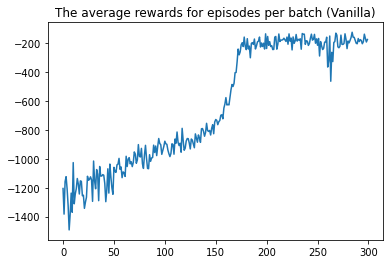

In [19]:
plt.plot(avg_ep_rews_log)
plt.title("The average rewards for episodes per batch (Vanilla)")
plt.show()

Train (subgaussian importance sampling)--

In [9]:
ITERATIONS = 300
model = PPO(network=FeedForwardNN, obs_dim = obs_dim, act_dim = act_dim, subgaussian = True, delta = 0.2)
#model.actor.load_checkpoint()
#model.critic.load_checkpoint()
model.actor.train()
model.critic.train()

tmp = 0.0

avg_ep_rews_log_02 = []

prg_bar = tqdm(range(ITERATIONS))
for i in prg_bar:
    batch_obs, batch_acts, batch_rews, batch_log_probs, batch_lens = \
        rollout(model, env, hyperparameters['timesteps_per_batch'], hyperparameters['max_timesteps_per_episode'])

    avg_ep_lens = np.mean(batch_lens)
    avg_ep_rews = np.mean([np.sum(ep_rews) for ep_rews in batch_rews])
    avg_ep_rews_log_02.append(avg_ep_rews)
    
    # Round decimal places for more aesthetic logging messages
    avg_ep_lens = str(round(avg_ep_lens, 2))
    avg_ep_rews_1 = str(round(avg_ep_rews, 2))

    print(f"-------------------- Iteration --------------------", flush=True)
    print(f"Average Episodic Length: {avg_ep_lens}", flush=True)
    print(f"Average Episodic Return: {avg_ep_rews_1}", flush=True)
    
    model.learn(batch_obs, batch_acts, batch_rews, batch_log_probs)
    if avg_ep_rews > tmp:
        model.actor.save_checkpoint()
        model.critic.save_checkpoint()
        print("Successfully save the model!",flush=True)
    tmp = avg_ep_rews
    

  0%|                                                                                          | 0/300 [00:00<?, ?it/s]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1311.26


  0%|▎                                                                                 | 1/300 [00:01<09:35,  1.92s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1464.95


  1%|▌                                                                                 | 2/300 [00:03<09:21,  1.88s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1602.19


  1%|▊                                                                                 | 3/300 [00:05<09:49,  1.98s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1385.61
Successfully save the model!


  1%|█                                                                                 | 4/300 [00:08<10:35,  2.15s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1495.0


  2%|█▎                                                                                | 5/300 [00:10<10:20,  2.10s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1379.55
Successfully save the model!


  2%|█▋                                                                                | 6/300 [00:12<10:05,  2.06s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1420.69


  2%|█▉                                                                                | 7/300 [00:14<09:53,  2.03s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1407.84
Successfully save the model!


  3%|██▏                                                                               | 8/300 [00:16<09:38,  1.98s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1401.07
Successfully save the model!


  3%|██▍                                                                               | 9/300 [00:18<09:30,  1.96s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1362.3
Successfully save the model!


  3%|██▋                                                                              | 10/300 [00:20<09:47,  2.03s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1375.06


  4%|██▉                                                                              | 11/300 [00:22<09:34,  1.99s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1339.5
Successfully save the model!


  4%|███▏                                                                             | 12/300 [00:24<09:28,  1.97s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1193.61
Successfully save the model!


  4%|███▌                                                                             | 13/300 [00:25<09:15,  1.94s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1256.73


  5%|███▊                                                                             | 14/300 [00:27<09:08,  1.92s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1232.79
Successfully save the model!


  5%|████                                                                             | 15/300 [00:29<08:50,  1.86s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1316.47


  5%|████▎                                                                            | 16/300 [00:31<08:50,  1.87s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1252.63
Successfully save the model!


  6%|████▌                                                                            | 17/300 [00:33<08:45,  1.86s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1089.9
Successfully save the model!


  6%|████▊                                                                            | 18/300 [00:35<08:49,  1.88s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1398.54


  6%|█████▏                                                                           | 19/300 [00:37<08:46,  1.87s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1339.97
Successfully save the model!


  7%|█████▍                                                                           | 20/300 [00:38<08:33,  1.83s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1310.73
Successfully save the model!


  7%|█████▋                                                                           | 21/300 [00:40<08:32,  1.84s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1379.09


  7%|█████▉                                                                           | 22/300 [00:42<08:36,  1.86s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1419.28


  8%|██████▏                                                                          | 23/300 [00:44<08:35,  1.86s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1348.92
Successfully save the model!


  8%|██████▍                                                                          | 24/300 [00:46<08:28,  1.84s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1438.16


  8%|██████▊                                                                          | 25/300 [00:47<08:24,  1.83s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1341.75
Successfully save the model!


  9%|███████                                                                          | 26/300 [00:49<08:17,  1.81s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1127.26
Successfully save the model!


  9%|███████▎                                                                         | 27/300 [00:51<08:18,  1.83s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1194.71


  9%|███████▌                                                                         | 28/300 [00:53<08:14,  1.82s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1230.78


 10%|███████▊                                                                         | 29/300 [00:55<08:13,  1.82s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1263.93


 10%|████████                                                                         | 30/300 [00:57<08:11,  1.82s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1151.74
Successfully save the model!


 10%|████████▎                                                                        | 31/300 [00:58<08:08,  1.81s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1164.15


 11%|████████▋                                                                        | 32/300 [01:00<08:07,  1.82s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1223.95


 11%|████████▉                                                                        | 33/300 [01:02<08:04,  1.81s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1284.07


 11%|█████████▏                                                                       | 34/300 [01:04<08:02,  1.82s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1023.93
Successfully save the model!


 12%|█████████▍                                                                       | 35/300 [01:06<08:03,  1.83s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1039.9


 12%|█████████▋                                                                       | 36/300 [01:07<07:59,  1.82s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1132.81


 12%|█████████▉                                                                       | 37/300 [01:09<07:57,  1.82s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1008.99
Successfully save the model!


 13%|██████████▎                                                                      | 38/300 [01:11<07:57,  1.82s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -986.76
Successfully save the model!


 13%|██████████▌                                                                      | 39/300 [01:13<07:56,  1.83s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1210.99


 13%|██████████▊                                                                      | 40/300 [01:15<07:54,  1.82s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1096.11
Successfully save the model!


 14%|███████████                                                                      | 41/300 [01:17<07:53,  1.83s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1092.6
Successfully save the model!


 14%|███████████▎                                                                     | 42/300 [01:18<07:50,  1.82s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1016.35
Successfully save the model!


 14%|███████████▌                                                                     | 43/300 [01:20<07:39,  1.79s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -990.58
Successfully save the model!


 15%|███████████▉                                                                     | 44/300 [01:22<07:45,  1.82s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1106.53


 15%|████████████▏                                                                    | 45/300 [01:24<07:41,  1.81s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1006.58
Successfully save the model!


 15%|████████████▍                                                                    | 46/300 [01:26<07:42,  1.82s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1084.1


 16%|████████████▋                                                                    | 47/300 [01:27<07:43,  1.83s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -997.05
Successfully save the model!


 16%|████████████▉                                                                    | 48/300 [01:29<07:42,  1.84s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -995.03
Successfully save the model!


 16%|█████████████▏                                                                   | 49/300 [01:31<07:37,  1.82s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1095.97


 17%|█████████████▌                                                                   | 50/300 [01:33<07:32,  1.81s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1041.66
Successfully save the model!


 17%|█████████████▊                                                                   | 51/300 [01:35<07:29,  1.81s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -976.31
Successfully save the model!


 17%|██████████████                                                                   | 52/300 [01:37<07:53,  1.91s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -956.7
Successfully save the model!


 18%|██████████████▎                                                                  | 53/300 [01:39<08:02,  1.95s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -997.36


 18%|██████████████▌                                                                  | 54/300 [01:41<07:45,  1.89s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1024.29


 18%|██████████████▊                                                                  | 55/300 [01:42<07:37,  1.87s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -948.61
Successfully save the model!


 19%|███████████████                                                                  | 56/300 [01:44<07:28,  1.84s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -915.41
Successfully save the model!


 19%|███████████████▍                                                                 | 57/300 [01:46<07:26,  1.84s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -845.79
Successfully save the model!


 19%|███████████████▋                                                                 | 58/300 [01:48<07:24,  1.84s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -946.11


 20%|███████████████▉                                                                 | 59/300 [01:50<07:22,  1.84s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -836.5
Successfully save the model!


 20%|████████████████▏                                                                | 60/300 [01:52<07:21,  1.84s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -881.69


 20%|████████████████▍                                                                | 61/300 [01:53<07:03,  1.77s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -863.59
Successfully save the model!


 21%|████████████████▋                                                                | 62/300 [01:55<07:01,  1.77s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -932.93


 21%|█████████████████                                                                | 63/300 [01:57<07:00,  1.77s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -918.12
Successfully save the model!


 21%|█████████████████▎                                                               | 64/300 [01:59<07:00,  1.78s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -940.46


 22%|█████████████████▌                                                               | 65/300 [02:00<06:57,  1.78s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -940.37
Successfully save the model!


 22%|█████████████████▊                                                               | 66/300 [02:02<07:00,  1.80s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -943.79


 22%|██████████████████                                                               | 67/300 [02:04<06:59,  1.80s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -895.88
Successfully save the model!


 23%|██████████████████▎                                                              | 68/300 [02:06<07:01,  1.82s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -891.07
Successfully save the model!


 23%|██████████████████▋                                                              | 69/300 [02:08<07:12,  1.87s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -950.28


 23%|██████████████████▉                                                              | 70/300 [02:10<07:05,  1.85s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -851.93
Successfully save the model!


 24%|███████████████████▏                                                             | 71/300 [02:11<07:01,  1.84s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -862.43


 24%|███████████████████▍                                                             | 72/300 [02:13<06:44,  1.78s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -901.81


 24%|███████████████████▋                                                             | 73/300 [02:15<06:41,  1.77s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -907.38


 25%|███████████████████▉                                                             | 74/300 [02:17<06:40,  1.77s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -920.31


 25%|████████████████████▎                                                            | 75/300 [02:18<06:41,  1.78s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -869.15
Successfully save the model!


 25%|████████████████████▌                                                            | 76/300 [02:20<06:41,  1.79s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -860.99
Successfully save the model!


 26%|████████████████████▊                                                            | 77/300 [02:22<06:42,  1.80s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -904.24


 26%|█████████████████████                                                            | 78/300 [02:24<06:41,  1.81s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -813.36
Successfully save the model!


 26%|█████████████████████▎                                                           | 79/300 [02:26<06:36,  1.80s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -852.25


 27%|█████████████████████▌                                                           | 80/300 [02:27<06:35,  1.80s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -878.34


 27%|█████████████████████▊                                                           | 81/300 [02:29<06:36,  1.81s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -825.99
Successfully save the model!


 27%|██████████████████████▏                                                          | 82/300 [02:31<06:54,  1.90s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -856.43


 28%|██████████████████████▍                                                          | 83/300 [02:33<06:54,  1.91s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -800.19
Successfully save the model!


 28%|██████████████████████▋                                                          | 84/300 [02:35<06:39,  1.85s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -903.46


 28%|██████████████████████▉                                                          | 85/300 [02:37<06:54,  1.93s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -898.18
Successfully save the model!


 29%|███████████████████████▏                                                         | 86/300 [02:39<07:08,  2.00s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -807.83
Successfully save the model!


 29%|███████████████████████▍                                                         | 87/300 [02:42<07:20,  2.07s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -852.56


 29%|███████████████████████▊                                                         | 88/300 [02:44<07:25,  2.10s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -789.79
Successfully save the model!


 30%|████████████████████████                                                         | 89/300 [02:46<07:35,  2.16s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -773.46
Successfully save the model!


 30%|████████████████████████▎                                                        | 90/300 [02:48<07:42,  2.20s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -837.78


 30%|████████████████████████▌                                                        | 91/300 [02:50<07:17,  2.09s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -794.63
Successfully save the model!


 31%|████████████████████████▊                                                        | 92/300 [02:52<06:58,  2.01s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -862.83


 31%|█████████████████████████                                                        | 93/300 [02:54<06:44,  1.95s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -826.08
Successfully save the model!


 31%|█████████████████████████▍                                                       | 94/300 [02:56<06:35,  1.92s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -765.33
Successfully save the model!


 32%|█████████████████████████▋                                                       | 95/300 [02:58<07:03,  2.07s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -780.63


 32%|█████████████████████████▉                                                       | 96/300 [03:00<07:05,  2.09s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -828.56


 32%|██████████████████████████▏                                                      | 97/300 [03:02<07:00,  2.07s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -846.36


 33%|██████████████████████████▍                                                      | 98/300 [03:04<06:41,  1.99s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -705.07
Successfully save the model!


 33%|██████████████████████████▋                                                      | 99/300 [03:06<06:44,  2.01s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -726.57


 33%|██████████████████████████▋                                                     | 100/300 [03:08<06:49,  2.05s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -743.29


 34%|██████████████████████████▉                                                     | 101/300 [03:10<06:33,  1.98s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -776.44


 34%|███████████████████████████▏                                                    | 102/300 [03:12<06:22,  1.93s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -822.78


 34%|███████████████████████████▍                                                    | 103/300 [03:14<06:12,  1.89s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -748.03
Successfully save the model!


 35%|███████████████████████████▋                                                    | 104/300 [03:15<05:55,  1.81s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -730.95
Successfully save the model!


 35%|████████████████████████████                                                    | 105/300 [03:17<05:51,  1.80s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -767.23


 35%|████████████████████████████▎                                                   | 106/300 [03:19<05:51,  1.81s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -664.87
Successfully save the model!


 36%|████████████████████████████▌                                                   | 107/300 [03:21<05:48,  1.80s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -693.89


 36%|████████████████████████████▊                                                   | 108/300 [03:23<05:47,  1.81s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -698.72


 36%|█████████████████████████████                                                   | 109/300 [03:24<05:34,  1.75s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -693.18
Successfully save the model!


 37%|█████████████████████████████▎                                                  | 110/300 [03:26<05:34,  1.76s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -630.54
Successfully save the model!


 37%|█████████████████████████████▌                                                  | 111/300 [03:28<05:35,  1.78s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -632.78


 37%|█████████████████████████████▊                                                  | 112/300 [03:30<05:34,  1.78s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -656.56


 38%|██████████████████████████████▏                                                 | 113/300 [03:31<05:35,  1.79s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -560.33
Successfully save the model!


 38%|██████████████████████████████▍                                                 | 114/300 [03:33<05:31,  1.78s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -544.75
Successfully save the model!


 38%|██████████████████████████████▋                                                 | 115/300 [03:35<05:28,  1.77s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -599.81


 39%|██████████████████████████████▉                                                 | 116/300 [03:36<05:19,  1.74s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -508.89
Successfully save the model!


 39%|███████████████████████████████▏                                                | 117/300 [03:38<05:18,  1.74s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -494.96
Successfully save the model!


 39%|███████████████████████████████▍                                                | 118/300 [03:40<05:21,  1.77s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -572.1


 40%|███████████████████████████████▋                                                | 119/300 [03:42<05:20,  1.77s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -541.55
Successfully save the model!


 40%|████████████████████████████████                                                | 120/300 [03:44<05:21,  1.79s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -572.36


 40%|████████████████████████████████▎                                               | 121/300 [03:45<05:20,  1.79s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -361.04
Successfully save the model!


 41%|████████████████████████████████▌                                               | 122/300 [03:47<05:11,  1.75s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -403.39


 41%|████████████████████████████████▊                                               | 123/300 [03:49<05:11,  1.76s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -220.02
Successfully save the model!


 41%|█████████████████████████████████                                               | 124/300 [03:51<05:08,  1.76s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -221.82


 42%|█████████████████████████████████▎                                              | 125/300 [03:52<05:10,  1.77s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -284.22


 42%|█████████████████████████████████▌                                              | 126/300 [03:54<05:08,  1.77s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -190.48
Successfully save the model!


 42%|█████████████████████████████████▊                                              | 127/300 [03:56<05:07,  1.78s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -276.49


 43%|██████████████████████████████████▏                                             | 128/300 [03:58<05:00,  1.75s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -209.24
Successfully save the model!


 43%|██████████████████████████████████▍                                             | 129/300 [04:00<05:02,  1.77s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -131.25
Successfully save the model!


 43%|██████████████████████████████████▋                                             | 130/300 [04:01<05:02,  1.78s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -174.59


 44%|██████████████████████████████████▉                                             | 131/300 [04:03<05:04,  1.80s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -291.19


 44%|███████████████████████████████████▏                                            | 132/300 [04:05<05:03,  1.81s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -246.96
Successfully save the model!


 44%|███████████████████████████████████▍                                            | 133/300 [04:07<05:14,  1.88s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -357.12


 45%|███████████████████████████████████▋                                            | 134/300 [04:09<05:10,  1.87s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -321.94
Successfully save the model!


 45%|████████████████████████████████████                                            | 135/300 [04:11<05:05,  1.85s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -299.92
Successfully save the model!


 45%|████████████████████████████████████▎                                           | 136/300 [04:13<05:01,  1.84s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -501.05


 46%|████████████████████████████████████▌                                           | 137/300 [04:14<04:57,  1.83s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -361.69
Successfully save the model!


 46%|████████████████████████████████████▊                                           | 138/300 [04:16<04:53,  1.81s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -310.05
Successfully save the model!


 46%|█████████████████████████████████████                                           | 139/300 [04:18<04:50,  1.80s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -343.37


 47%|█████████████████████████████████████▎                                          | 140/300 [04:20<04:49,  1.81s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -165.19
Successfully save the model!


 47%|█████████████████████████████████████▌                                          | 141/300 [04:21<04:41,  1.77s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -310.67


 47%|█████████████████████████████████████▊                                          | 142/300 [04:23<04:38,  1.76s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -238.11
Successfully save the model!


 48%|██████████████████████████████████████▏                                         | 143/300 [04:25<04:36,  1.76s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -241.65


 48%|██████████████████████████████████████▍                                         | 144/300 [04:27<04:35,  1.76s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -171.99
Successfully save the model!


 48%|██████████████████████████████████████▋                                         | 145/300 [04:28<04:32,  1.76s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -241.62


 49%|██████████████████████████████████████▉                                         | 146/300 [04:30<04:36,  1.79s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -210.62
Successfully save the model!


 49%|███████████████████████████████████████▏                                        | 147/300 [04:32<04:41,  1.84s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -213.03


 49%|███████████████████████████████████████▍                                        | 148/300 [04:34<04:45,  1.88s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -190.67
Successfully save the model!


 50%|███████████████████████████████████████▋                                        | 149/300 [04:36<04:42,  1.87s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -340.25


 50%|████████████████████████████████████████                                        | 150/300 [04:38<04:53,  1.96s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -202.18
Successfully save the model!


 50%|████████████████████████████████████████▎                                       | 151/300 [04:40<04:49,  1.94s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -212.12


 51%|████████████████████████████████████████▌                                       | 152/300 [04:42<04:46,  1.94s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -162.4
Successfully save the model!


 51%|████████████████████████████████████████▊                                       | 153/300 [04:44<04:41,  1.91s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -185.37


 51%|█████████████████████████████████████████                                       | 154/300 [04:46<04:36,  1.89s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -237.4


 52%|█████████████████████████████████████████▎                                      | 155/300 [04:48<04:36,  1.90s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -218.84
Successfully save the model!


 52%|█████████████████████████████████████████▌                                      | 156/300 [04:49<04:28,  1.86s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -271.15


 52%|█████████████████████████████████████████▊                                      | 157/300 [04:51<04:21,  1.83s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -274.72


 53%|██████████████████████████████████████████▏                                     | 158/300 [04:53<04:25,  1.87s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -223.17
Successfully save the model!


 53%|██████████████████████████████████████████▍                                     | 159/300 [04:55<04:39,  1.98s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -191.78
Successfully save the model!


 53%|██████████████████████████████████████████▋                                     | 160/300 [04:58<04:48,  2.06s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -209.24


 54%|██████████████████████████████████████████▉                                     | 161/300 [05:00<04:47,  2.07s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -394.6


 54%|███████████████████████████████████████████▏                                    | 162/300 [05:02<04:38,  2.02s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -196.44
Successfully save the model!


 54%|███████████████████████████████████████████▍                                    | 163/300 [05:04<04:32,  1.99s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -212.65


 55%|███████████████████████████████████████████▋                                    | 164/300 [05:06<04:35,  2.02s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -214.37


 55%|████████████████████████████████████████████                                    | 165/300 [05:08<04:30,  2.00s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -149.42
Successfully save the model!


 55%|████████████████████████████████████████████▎                                   | 166/300 [05:10<04:29,  2.01s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -234.67


 56%|████████████████████████████████████████████▌                                   | 167/300 [05:12<04:43,  2.13s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -182.35
Successfully save the model!


 56%|████████████████████████████████████████████▊                                   | 168/300 [05:14<04:44,  2.15s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -90.57
Successfully save the model!


 56%|█████████████████████████████████████████████                                   | 169/300 [05:16<04:26,  2.04s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -166.23


 57%|█████████████████████████████████████████████▎                                  | 170/300 [05:18<04:24,  2.03s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -197.37


 57%|█████████████████████████████████████████████▌                                  | 171/300 [05:20<04:35,  2.14s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -186.58
Successfully save the model!


 57%|█████████████████████████████████████████████▊                                  | 172/300 [05:23<04:47,  2.25s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -202.47


 58%|██████████████████████████████████████████████▏                                 | 173/300 [05:25<04:53,  2.31s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -118.12
Successfully save the model!


 58%|██████████████████████████████████████████████▍                                 | 174/300 [05:27<04:42,  2.24s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -288.11


 58%|██████████████████████████████████████████████▋                                 | 175/300 [05:30<04:34,  2.20s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -367.24


 59%|██████████████████████████████████████████████▉                                 | 176/300 [05:32<04:57,  2.40s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -157.93
Successfully save the model!


 59%|███████████████████████████████████████████████▏                                | 177/300 [05:35<05:03,  2.47s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -188.8


 59%|███████████████████████████████████████████████▍                                | 178/300 [05:37<04:50,  2.38s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -198.72


 60%|███████████████████████████████████████████████▋                                | 179/300 [05:39<04:41,  2.33s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -278.85


 60%|████████████████████████████████████████████████                                | 180/300 [05:42<04:31,  2.27s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -216.49
Successfully save the model!


 60%|████████████████████████████████████████████████▎                               | 181/300 [05:44<04:20,  2.19s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -216.58


 61%|████████████████████████████████████████████████▌                               | 182/300 [05:46<04:20,  2.20s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -150.93
Successfully save the model!


 61%|████████████████████████████████████████████████▊                               | 183/300 [05:48<04:28,  2.30s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -250.55


 61%|█████████████████████████████████████████████████                               | 184/300 [05:51<04:26,  2.30s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -183.87
Successfully save the model!


 62%|█████████████████████████████████████████████████▎                              | 185/300 [05:53<04:27,  2.33s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -149.65
Successfully save the model!


 62%|█████████████████████████████████████████████████▌                              | 186/300 [05:56<04:43,  2.48s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -147.0
Successfully save the model!


 62%|█████████████████████████████████████████████████▊                              | 187/300 [05:58<04:27,  2.37s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -168.01


 63%|██████████████████████████████████████████████████▏                             | 188/300 [06:00<04:22,  2.34s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -200.17


 63%|██████████████████████████████████████████████████▍                             | 189/300 [06:03<04:40,  2.52s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -183.71
Successfully save the model!


 63%|██████████████████████████████████████████████████▋                             | 190/300 [06:05<04:23,  2.40s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -239.91


 64%|██████████████████████████████████████████████████▉                             | 191/300 [06:08<04:21,  2.40s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -152.53
Successfully save the model!


 64%|███████████████████████████████████████████████████▏                            | 192/300 [06:10<04:18,  2.39s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -173.18


 64%|███████████████████████████████████████████████████▍                            | 193/300 [06:13<04:24,  2.48s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -214.3


 65%|███████████████████████████████████████████████████▋                            | 194/300 [06:15<04:14,  2.40s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -238.1


 65%|████████████████████████████████████████████████████                            | 195/300 [06:17<04:08,  2.36s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -157.19
Successfully save the model!


 65%|████████████████████████████████████████████████████▎                           | 196/300 [06:19<03:50,  2.22s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -219.13


 66%|████████████████████████████████████████████████████▌                           | 197/300 [06:21<03:47,  2.21s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -241.17


 66%|████████████████████████████████████████████████████▊                           | 198/300 [06:23<03:39,  2.15s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -259.4


 66%|█████████████████████████████████████████████████████                           | 199/300 [06:25<03:30,  2.08s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -200.26
Successfully save the model!


 67%|█████████████████████████████████████████████████████▎                          | 200/300 [06:27<03:25,  2.05s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -160.68
Successfully save the model!


 67%|█████████████████████████████████████████████████████▌                          | 201/300 [06:29<03:16,  1.98s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -223.79


 67%|█████████████████████████████████████████████████████▊                          | 202/300 [06:31<03:12,  1.97s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -195.33
Successfully save the model!


 68%|██████████████████████████████████████████████████████▏                         | 203/300 [06:33<03:22,  2.09s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -124.68
Successfully save the model!


 68%|██████████████████████████████████████████████████████▍                         | 204/300 [06:36<03:23,  2.11s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -135.26


 68%|██████████████████████████████████████████████████████▋                         | 205/300 [06:38<03:30,  2.22s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -181.01


 69%|██████████████████████████████████████████████████████▉                         | 206/300 [06:40<03:15,  2.08s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -225.95


 69%|███████████████████████████████████████████████████████▏                        | 207/300 [06:42<03:06,  2.01s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -193.38
Successfully save the model!


 69%|███████████████████████████████████████████████████████▍                        | 208/300 [06:43<02:59,  1.95s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -177.56
Successfully save the model!


 70%|███████████████████████████████████████████████████████▋                        | 209/300 [06:45<02:51,  1.89s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -181.95


 70%|████████████████████████████████████████████████████████                        | 210/300 [06:47<02:47,  1.86s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -147.75
Successfully save the model!


 70%|████████████████████████████████████████████████████████▎                       | 211/300 [06:49<02:44,  1.84s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -166.94


 71%|████████████████████████████████████████████████████████▌                       | 212/300 [06:50<02:38,  1.80s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -188.52


 71%|████████████████████████████████████████████████████████▊                       | 213/300 [06:52<02:36,  1.80s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -173.27
Successfully save the model!


 71%|█████████████████████████████████████████████████████████                       | 214/300 [06:54<02:33,  1.79s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -180.35


 72%|█████████████████████████████████████████████████████████▎                      | 215/300 [06:56<02:44,  1.94s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -147.48
Successfully save the model!


 72%|█████████████████████████████████████████████████████████▌                      | 216/300 [06:59<02:56,  2.10s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -229.63


 72%|█████████████████████████████████████████████████████████▊                      | 217/300 [07:01<02:55,  2.12s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -214.92
Successfully save the model!


 73%|██████████████████████████████████████████████████████████▏                     | 218/300 [07:03<02:55,  2.14s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -127.43
Successfully save the model!


 73%|██████████████████████████████████████████████████████████▍                     | 219/300 [07:05<02:56,  2.18s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -161.13


 73%|██████████████████████████████████████████████████████████▋                     | 220/300 [07:07<02:52,  2.16s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -189.55


 74%|██████████████████████████████████████████████████████████▉                     | 221/300 [07:09<02:44,  2.09s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -185.15
Successfully save the model!


 74%|███████████████████████████████████████████████████████████▏                    | 222/300 [07:11<02:41,  2.07s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -193.54


 74%|███████████████████████████████████████████████████████████▍                    | 223/300 [07:13<02:31,  1.97s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -134.89
Successfully save the model!


 75%|███████████████████████████████████████████████████████████▋                    | 224/300 [07:15<02:29,  1.97s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -180.22


 75%|████████████████████████████████████████████████████████████                    | 225/300 [07:17<02:24,  1.93s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -155.07
Successfully save the model!


 75%|████████████████████████████████████████████████████████████▎                   | 226/300 [07:19<02:19,  1.89s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -182.86


 76%|████████████████████████████████████████████████████████████▌                   | 227/300 [07:21<02:16,  1.87s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -200.65


 76%|████████████████████████████████████████████████████████████▊                   | 228/300 [07:22<02:13,  1.85s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -133.97
Successfully save the model!


 76%|█████████████████████████████████████████████████████████████                   | 229/300 [07:24<02:10,  1.84s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -114.99
Successfully save the model!


 77%|█████████████████████████████████████████████████████████████▎                  | 230/300 [07:26<02:05,  1.79s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -192.98


 77%|█████████████████████████████████████████████████████████████▌                  | 231/300 [07:28<02:03,  1.79s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -145.24
Successfully save the model!


 77%|█████████████████████████████████████████████████████████████▊                  | 232/300 [07:30<02:02,  1.81s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -175.21


 78%|██████████████████████████████████████████████████████████████▏                 | 233/300 [07:31<02:01,  1.81s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -166.75
Successfully save the model!


 78%|██████████████████████████████████████████████████████████████▍                 | 234/300 [07:33<01:59,  1.80s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -157.64
Successfully save the model!


 78%|██████████████████████████████████████████████████████████████▋                 | 235/300 [07:35<01:55,  1.77s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -160.59


 79%|██████████████████████████████████████████████████████████████▉                 | 236/300 [07:37<01:54,  1.79s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -155.81
Successfully save the model!


 79%|███████████████████████████████████████████████████████████████▏                | 237/300 [07:38<01:52,  1.79s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -159.51


 79%|███████████████████████████████████████████████████████████████▍                | 238/300 [07:40<01:51,  1.81s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -166.73


 80%|███████████████████████████████████████████████████████████████▋                | 239/300 [07:42<01:50,  1.82s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -158.27
Successfully save the model!


 80%|████████████████████████████████████████████████████████████████                | 240/300 [07:44<01:48,  1.80s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -194.81


 80%|████████████████████████████████████████████████████████████████▎               | 241/300 [07:46<01:44,  1.78s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -193.08
Successfully save the model!


 81%|████████████████████████████████████████████████████████████████▌               | 242/300 [07:47<01:43,  1.78s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -224.07


 81%|████████████████████████████████████████████████████████████████▊               | 243/300 [07:49<01:41,  1.79s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -223.56
Successfully save the model!


 81%|█████████████████████████████████████████████████████████████████               | 244/300 [07:51<01:41,  1.81s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -136.56
Successfully save the model!


 82%|█████████████████████████████████████████████████████████████████▎              | 245/300 [07:53<01:41,  1.84s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -188.46


 82%|█████████████████████████████████████████████████████████████████▌              | 246/300 [07:55<01:39,  1.85s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -160.62
Successfully save the model!


 82%|█████████████████████████████████████████████████████████████████▊              | 247/300 [07:57<01:38,  1.86s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -258.27


 83%|██████████████████████████████████████████████████████████████████▏             | 248/300 [07:59<01:35,  1.84s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -170.84
Successfully save the model!


 83%|██████████████████████████████████████████████████████████████████▍             | 249/300 [08:00<01:33,  1.84s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -125.31
Successfully save the model!


 83%|██████████████████████████████████████████████████████████████████▋             | 250/300 [08:02<01:32,  1.84s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -204.14


 84%|██████████████████████████████████████████████████████████████████▉             | 251/300 [08:04<01:28,  1.80s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -145.48
Successfully save the model!


 84%|███████████████████████████████████████████████████████████████████▏            | 252/300 [08:06<01:28,  1.85s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -90.93
Successfully save the model!


 84%|███████████████████████████████████████████████████████████████████▍            | 253/300 [08:08<01:30,  1.93s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -227.39


 85%|███████████████████████████████████████████████████████████████████▋            | 254/300 [08:10<01:32,  2.02s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -180.1
Successfully save the model!


 85%|████████████████████████████████████████████████████████████████████            | 255/300 [08:13<01:37,  2.16s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -148.44
Successfully save the model!


 85%|████████████████████████████████████████████████████████████████████▎           | 256/300 [08:15<01:41,  2.31s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -168.9


 86%|████████████████████████████████████████████████████████████████████▌           | 257/300 [08:18<01:43,  2.41s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -180.01


 86%|████████████████████████████████████████████████████████████████████▊           | 258/300 [08:20<01:36,  2.29s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -99.34
Successfully save the model!


 86%|█████████████████████████████████████████████████████████████████████           | 259/300 [08:22<01:30,  2.20s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -134.84


 87%|█████████████████████████████████████████████████████████████████████▎          | 260/300 [08:24<01:25,  2.13s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -139.46


 87%|█████████████████████████████████████████████████████████████████████▌          | 261/300 [08:26<01:20,  2.07s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -145.63


 87%|█████████████████████████████████████████████████████████████████████▊          | 262/300 [08:28<01:15,  1.99s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -146.3


 88%|██████████████████████████████████████████████████████████████████████▏         | 263/300 [08:30<01:12,  1.96s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -139.63
Successfully save the model!


 88%|██████████████████████████████████████████████████████████████████████▍         | 264/300 [08:32<01:10,  1.96s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -144.47


 88%|██████████████████████████████████████████████████████████████████████▋         | 265/300 [08:33<01:07,  1.93s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -120.22
Successfully save the model!


 89%|██████████████████████████████████████████████████████████████████████▉         | 266/300 [08:35<01:06,  1.96s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -175.78


 89%|███████████████████████████████████████████████████████████████████████▏        | 267/300 [08:37<01:04,  1.95s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -151.28
Successfully save the model!


 89%|███████████████████████████████████████████████████████████████████████▍        | 268/300 [08:39<01:01,  1.92s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -202.8


 90%|███████████████████████████████████████████████████████████████████████▋        | 269/300 [08:41<00:58,  1.90s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -120.68
Successfully save the model!


 90%|████████████████████████████████████████████████████████████████████████        | 270/300 [08:43<00:57,  1.93s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -187.79


 90%|████████████████████████████████████████████████████████████████████████▎       | 271/300 [08:45<00:54,  1.89s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -195.04


 91%|████████████████████████████████████████████████████████████████████████▌       | 272/300 [08:47<00:52,  1.88s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -190.1
Successfully save the model!


 91%|████████████████████████████████████████████████████████████████████████▊       | 273/300 [08:49<00:50,  1.87s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -135.74
Successfully save the model!


 91%|█████████████████████████████████████████████████████████████████████████       | 274/300 [08:51<00:48,  1.88s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -171.95


 92%|█████████████████████████████████████████████████████████████████████████▎      | 275/300 [08:52<00:47,  1.88s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -275.86


 92%|█████████████████████████████████████████████████████████████████████████▌      | 276/300 [08:54<00:46,  1.93s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -137.17
Successfully save the model!


 92%|█████████████████████████████████████████████████████████████████████████▊      | 277/300 [08:57<00:45,  2.00s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -159.54


 93%|██████████████████████████████████████████████████████████████████████████▏     | 278/300 [08:59<00:45,  2.08s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -201.94


 93%|██████████████████████████████████████████████████████████████████████████▍     | 279/300 [09:01<00:41,  1.99s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -157.97
Successfully save the model!


 93%|██████████████████████████████████████████████████████████████████████████▋     | 280/300 [09:03<00:40,  2.00s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -274.35


 94%|██████████████████████████████████████████████████████████████████████████▉     | 281/300 [09:05<00:38,  2.03s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -241.98
Successfully save the model!


 94%|███████████████████████████████████████████████████████████████████████████▏    | 282/300 [09:07<00:37,  2.06s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -183.84
Successfully save the model!


 94%|███████████████████████████████████████████████████████████████████████████▍    | 283/300 [09:09<00:33,  1.99s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -102.6
Successfully save the model!


 95%|███████████████████████████████████████████████████████████████████████████▋    | 284/300 [09:11<00:31,  2.00s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -183.05


 95%|████████████████████████████████████████████████████████████████████████████    | 285/300 [09:13<00:29,  1.97s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -154.72
Successfully save the model!


 95%|████████████████████████████████████████████████████████████████████████████▎   | 286/300 [09:15<00:27,  1.94s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -187.37


 96%|████████████████████████████████████████████████████████████████████████████▌   | 287/300 [09:16<00:25,  1.94s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -181.88
Successfully save the model!


 96%|████████████████████████████████████████████████████████████████████████████▊   | 288/300 [09:18<00:23,  1.92s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -194.56


 96%|█████████████████████████████████████████████████████████████████████████████   | 289/300 [09:20<00:20,  1.89s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -170.07
Successfully save the model!


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 290/300 [09:22<00:18,  1.90s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -187.32


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 291/300 [09:24<00:16,  1.84s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -145.45
Successfully save the model!


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 292/300 [09:26<00:14,  1.83s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -198.38


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 293/300 [09:27<00:12,  1.84s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -178.6
Successfully save the model!


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 294/300 [09:30<00:11,  1.95s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -180.56


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 295/300 [09:32<00:10,  2.01s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -122.74
Successfully save the model!


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 296/300 [09:34<00:07,  1.97s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -112.74
Successfully save the model!


 99%|███████████████████████████████████████████████████████████████████████████████▏| 297/300 [09:35<00:05,  1.88s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -121.38


 99%|███████████████████████████████████████████████████████████████████████████████▍| 298/300 [09:37<00:03,  1.84s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -140.37


100%|███████████████████████████████████████████████████████████████████████████████▋| 299/300 [09:39<00:01,  1.80s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -136.57
Successfully save the model!


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [09:41<00:00,  1.94s/it]


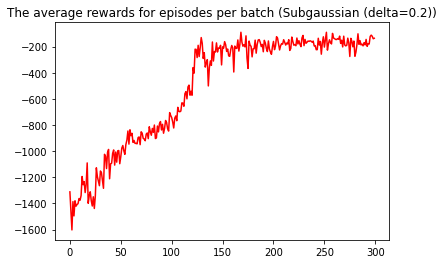

In [10]:
plt.plot(avg_ep_rews_log_02, color='red')
plt.title("The average rewards for episodes per batch (Subgaussian (delta=0.2))")
plt.show()

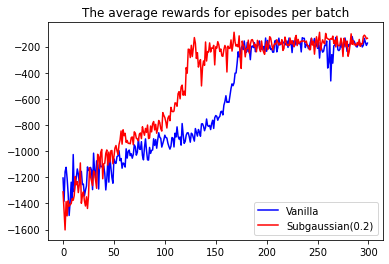

In [13]:
line0, = plt.plot(avg_ep_rews_log[0:300], color = 'blue')
line1, = plt.plot(avg_ep_rews_log_02[0:300], color = 'red')
plt.legend(handles = [line0, line1], labels =['Vanilla', 'Subgaussian(0.2)'], loc='lower right')
plt.title("The average rewards for episodes per batch")
plt.show()

In [14]:
ITERATIONS = 300

model = PPO(network=FeedForwardNN, obs_dim = obs_dim, act_dim = act_dim, subgaussian = True, delta = 0.4)
#model.actor.load_checkpoint()
#model.critic.load_checkpoint()
model.actor.train()
model.critic.train()

tmp = 0.0

avg_ep_rews_log_04 = []

prg_bar = tqdm(range(ITERATIONS))
for i in prg_bar:
    batch_obs, batch_acts, batch_rews, batch_log_probs, batch_lens = \
        rollout(model, env, hyperparameters['timesteps_per_batch'], hyperparameters['max_timesteps_per_episode'])

    avg_ep_lens = np.mean(batch_lens)
    avg_ep_rews = np.mean([np.sum(ep_rews) for ep_rews in batch_rews])
    avg_ep_rews_log_04.append(avg_ep_rews)
    
    # Round decimal places for more aesthetic logging messages
    avg_ep_lens = str(round(avg_ep_lens, 2))
    avg_ep_rews_1 = str(round(avg_ep_rews, 2))

    print(f"-------------------- Iteration --------------------", flush=True)
    print(f"Average Episodic Length: {avg_ep_lens}", flush=True)
    print(f"Average Episodic Return: {avg_ep_rews_1}", flush=True)
    
    model.learn(batch_obs, batch_acts, batch_rews, batch_log_probs)
    if avg_ep_rews > tmp:
        model.actor.save_checkpoint()
        model.critic.save_checkpoint()
        print("Successfully save the model!",flush=True)
    tmp = avg_ep_rews
    

  0%|                                                                                          | 0/300 [00:00<?, ?it/s]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1132.58


  0%|▎                                                                                 | 1/300 [00:02<10:09,  2.04s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1294.59


  1%|▌                                                                                 | 2/300 [00:03<09:46,  1.97s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1206.07
Successfully save the model!


  1%|▊                                                                                 | 3/300 [00:05<09:49,  1.98s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1173.47
Successfully save the model!


  1%|█                                                                                 | 4/300 [00:07<09:28,  1.92s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1090.87
Successfully save the model!


  2%|█▎                                                                                | 5/300 [00:09<09:06,  1.85s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1139.28


  2%|█▋                                                                                | 6/300 [00:11<08:51,  1.81s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1114.33
Successfully save the model!


  2%|█▉                                                                                | 7/300 [00:13<08:48,  1.80s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1216.71


  3%|██▏                                                                               | 8/300 [00:14<08:35,  1.77s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1124.47
Successfully save the model!


  3%|██▍                                                                               | 9/300 [00:16<08:40,  1.79s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1128.78


  3%|██▋                                                                              | 10/300 [00:18<08:28,  1.75s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1163.68


  4%|██▉                                                                              | 11/300 [00:20<08:58,  1.86s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1207.1


  4%|███▏                                                                             | 12/300 [00:22<08:51,  1.84s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1110.01
Successfully save the model!


  4%|███▌                                                                             | 13/300 [00:23<08:46,  1.83s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1036.19
Successfully save the model!


  5%|███▊                                                                             | 14/300 [00:25<08:53,  1.86s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1199.22


  5%|████                                                                             | 15/300 [00:27<09:09,  1.93s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1207.03


  5%|████▎                                                                            | 16/300 [00:29<09:13,  1.95s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1103.35
Successfully save the model!


  6%|████▌                                                                            | 17/300 [00:31<09:16,  1.97s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1066.29
Successfully save the model!


  6%|████▊                                                                            | 18/300 [00:33<09:13,  1.96s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1124.98


  6%|█████▏                                                                           | 19/300 [00:35<09:04,  1.94s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1145.28


  7%|█████▍                                                                           | 20/300 [00:37<09:10,  1.96s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1111.11
Successfully save the model!


  7%|█████▋                                                                           | 21/300 [00:39<08:57,  1.93s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1149.08


  7%|█████▉                                                                           | 22/300 [00:41<08:49,  1.91s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1054.31
Successfully save the model!


  8%|██████▏                                                                          | 23/300 [00:43<08:31,  1.85s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1054.05
Successfully save the model!


  8%|██████▍                                                                          | 24/300 [00:45<08:31,  1.85s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1122.66


  8%|██████▊                                                                          | 25/300 [00:47<08:36,  1.88s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1089.28
Successfully save the model!


  9%|███████                                                                          | 26/300 [00:48<08:30,  1.86s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1051.75
Successfully save the model!


  9%|███████▎                                                                         | 27/300 [00:50<08:17,  1.82s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1138.49


  9%|███████▌                                                                         | 28/300 [00:52<08:05,  1.79s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1097.75
Successfully save the model!


 10%|███████▊                                                                         | 29/300 [00:54<08:14,  1.82s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1023.84
Successfully save the model!


 10%|████████                                                                         | 30/300 [00:56<08:19,  1.85s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1029.76


 10%|████████▎                                                                        | 31/300 [00:57<08:07,  1.81s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1056.91


 11%|████████▋                                                                        | 32/300 [00:59<08:09,  1.83s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1034.07
Successfully save the model!


 11%|████████▉                                                                        | 33/300 [01:02<08:55,  2.00s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1062.85


 11%|█████████▏                                                                       | 34/300 [01:04<08:58,  2.02s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1001.0
Successfully save the model!


 12%|█████████▍                                                                       | 35/300 [01:06<08:51,  2.01s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -986.09
Successfully save the model!


 12%|█████████▋                                                                       | 36/300 [01:08<08:38,  1.97s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -961.35
Successfully save the model!


 12%|█████████▉                                                                       | 37/300 [01:09<08:20,  1.90s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -957.04
Successfully save the model!


 13%|██████████▎                                                                      | 38/300 [01:11<08:07,  1.86s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -999.79


 13%|██████████▌                                                                      | 39/300 [01:13<08:02,  1.85s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -955.52
Successfully save the model!


 13%|██████████▊                                                                      | 40/300 [01:15<07:51,  1.81s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -885.19
Successfully save the model!


 14%|███████████                                                                      | 41/300 [01:16<07:45,  1.80s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -940.56


 14%|███████████▎                                                                     | 42/300 [01:18<07:37,  1.77s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -991.1


 14%|███████████▌                                                                     | 43/300 [01:20<07:51,  1.84s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1010.44


 15%|███████████▉                                                                     | 44/300 [01:22<07:54,  1.85s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -860.96
Successfully save the model!


 15%|████████████▏                                                                    | 45/300 [01:24<07:49,  1.84s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -997.42


 15%|████████████▍                                                                    | 46/300 [01:26<07:52,  1.86s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -898.82
Successfully save the model!


 16%|████████████▋                                                                    | 47/300 [01:28<07:53,  1.87s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1006.76


 16%|████████████▉                                                                    | 48/300 [01:29<07:44,  1.84s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1058.42


 16%|█████████████▏                                                                   | 49/300 [01:31<07:39,  1.83s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1049.78
Successfully save the model!


 17%|█████████████▌                                                                   | 50/300 [01:33<07:32,  1.81s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1006.85
Successfully save the model!


 17%|█████████████▊                                                                   | 51/300 [01:35<07:36,  1.83s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1097.3


 17%|██████████████                                                                   | 52/300 [01:37<07:31,  1.82s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -964.94
Successfully save the model!


 18%|██████████████▎                                                                  | 53/300 [01:38<07:26,  1.81s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -974.79


 18%|██████████████▌                                                                  | 54/300 [01:40<07:24,  1.81s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1000.77


 18%|██████████████▊                                                                  | 55/300 [01:42<07:28,  1.83s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1017.38


 19%|███████████████                                                                  | 56/300 [01:44<07:33,  1.86s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1066.79


 19%|███████████████▍                                                                 | 57/300 [01:46<07:36,  1.88s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -968.53
Successfully save the model!


 19%|███████████████▋                                                                 | 58/300 [01:48<07:26,  1.85s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1039.09


 20%|███████████████▉                                                                 | 59/300 [01:49<07:15,  1.81s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1001.13
Successfully save the model!


 20%|████████████████▏                                                                | 60/300 [01:51<07:08,  1.79s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1038.62


 20%|████████████████▍                                                                | 61/300 [01:53<07:05,  1.78s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -985.26
Successfully save the model!


 21%|████████████████▋                                                                | 62/300 [01:55<07:00,  1.77s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1079.84


 21%|█████████████████                                                                | 63/300 [01:56<06:59,  1.77s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1062.95
Successfully save the model!


 21%|█████████████████▎                                                               | 64/300 [01:58<06:56,  1.77s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -950.69
Successfully save the model!


 22%|█████████████████▌                                                               | 65/300 [02:00<06:58,  1.78s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -1008.44


 22%|█████████████████▊                                                               | 66/300 [02:02<07:10,  1.84s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -924.21
Successfully save the model!


 22%|██████████████████                                                               | 67/300 [02:04<07:19,  1.89s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -913.22
Successfully save the model!


 23%|██████████████████▎                                                              | 68/300 [02:06<07:19,  1.90s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -950.37


 23%|██████████████████▋                                                              | 69/300 [02:08<07:15,  1.89s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -975.91


 23%|██████████████████▉                                                              | 70/300 [02:10<07:09,  1.87s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -938.67
Successfully save the model!


 24%|███████████████████▏                                                             | 71/300 [02:11<07:11,  1.88s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -965.0


 24%|███████████████████▍                                                             | 72/300 [02:14<07:23,  1.95s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -927.76
Successfully save the model!


 24%|███████████████████▋                                                             | 73/300 [02:15<07:18,  1.93s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -929.32


 25%|███████████████████▉                                                             | 74/300 [02:17<07:09,  1.90s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -982.33


 25%|████████████████████▎                                                            | 75/300 [02:19<07:02,  1.88s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -921.66
Successfully save the model!


 25%|████████████████████▌                                                            | 76/300 [02:21<07:02,  1.89s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -949.85


 26%|████████████████████▊                                                            | 77/300 [02:23<06:49,  1.84s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -889.34
Successfully save the model!


 26%|█████████████████████                                                            | 78/300 [02:25<06:51,  1.85s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -909.22


 26%|█████████████████████▎                                                           | 79/300 [02:26<06:49,  1.85s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -964.67


 27%|█████████████████████▌                                                           | 80/300 [02:29<07:01,  1.92s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -857.12
Successfully save the model!


 27%|█████████████████████▊                                                           | 81/300 [02:30<06:54,  1.89s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -889.29


 27%|██████████████████████▏                                                          | 82/300 [02:32<06:49,  1.88s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -860.15
Successfully save the model!


 28%|██████████████████████▍                                                          | 83/300 [02:34<07:02,  1.95s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -873.46


 28%|██████████████████████▋                                                          | 84/300 [02:36<06:47,  1.89s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -956.36


 28%|██████████████████████▉                                                          | 85/300 [02:38<06:48,  1.90s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -807.9
Successfully save the model!


 29%|███████████████████████▏                                                         | 86/300 [02:40<06:36,  1.85s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -836.94


 29%|███████████████████████▍                                                         | 87/300 [02:41<06:26,  1.81s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -885.98


 29%|███████████████████████▊                                                         | 88/300 [02:43<06:22,  1.80s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -739.45
Successfully save the model!


 30%|████████████████████████                                                         | 89/300 [02:45<06:17,  1.79s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -887.0


 30%|████████████████████████▎                                                        | 90/300 [02:47<06:07,  1.75s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -807.45
Successfully save the model!


 30%|████████████████████████▌                                                        | 91/300 [02:48<06:05,  1.75s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -843.79


 31%|████████████████████████▊                                                        | 92/300 [02:50<06:10,  1.78s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -773.75
Successfully save the model!


 31%|█████████████████████████                                                        | 93/300 [02:52<06:19,  1.83s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -826.99


 31%|█████████████████████████▍                                                       | 94/300 [02:54<06:17,  1.83s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -806.87
Successfully save the model!


 32%|█████████████████████████▋                                                       | 95/300 [02:56<06:16,  1.83s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -793.58
Successfully save the model!


 32%|█████████████████████████▉                                                       | 96/300 [02:58<06:16,  1.85s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -890.24


 32%|██████████████████████████▏                                                      | 97/300 [03:00<06:38,  1.96s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -826.54
Successfully save the model!


 33%|██████████████████████████▍                                                      | 98/300 [03:02<06:26,  1.92s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -850.21


 33%|██████████████████████████▋                                                      | 99/300 [03:04<06:14,  1.86s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -846.49
Successfully save the model!


 33%|██████████████████████████▋                                                     | 100/300 [03:05<06:07,  1.84s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -871.55


 34%|██████████████████████████▉                                                     | 101/300 [03:07<06:07,  1.85s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -903.06


 34%|███████████████████████████▏                                                    | 102/300 [03:09<06:01,  1.83s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -849.65
Successfully save the model!


 34%|███████████████████████████▍                                                    | 103/300 [03:11<06:04,  1.85s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -839.88
Successfully save the model!


 35%|███████████████████████████▋                                                    | 104/300 [03:13<06:02,  1.85s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -844.44


 35%|████████████████████████████                                                    | 105/300 [03:15<06:04,  1.87s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -823.43
Successfully save the model!


 35%|████████████████████████████▎                                                   | 106/300 [03:16<06:00,  1.86s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -774.08
Successfully save the model!


 36%|████████████████████████████▌                                                   | 107/300 [03:18<06:05,  1.89s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -833.02


 36%|████████████████████████████▊                                                   | 108/300 [03:20<05:57,  1.86s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -722.16
Successfully save the model!


 36%|█████████████████████████████                                                   | 109/300 [03:22<05:51,  1.84s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -692.49
Successfully save the model!


 37%|█████████████████████████████▎                                                  | 110/300 [03:24<06:00,  1.90s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -759.08


 37%|█████████████████████████████▌                                                  | 111/300 [03:26<06:11,  1.96s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -756.72
Successfully save the model!


 37%|█████████████████████████████▊                                                  | 112/300 [03:28<06:09,  1.97s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -699.83
Successfully save the model!


 38%|██████████████████████████████▏                                                 | 113/300 [03:30<06:13,  2.00s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -733.68


 38%|██████████████████████████████▍                                                 | 114/300 [03:32<05:55,  1.91s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -747.57


 38%|██████████████████████████████▋                                                 | 115/300 [03:34<06:06,  1.98s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -711.09
Successfully save the model!


 39%|██████████████████████████████▉                                                 | 116/300 [03:36<06:05,  1.99s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -748.14


 39%|███████████████████████████████▏                                                | 117/300 [03:38<05:49,  1.91s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -693.14
Successfully save the model!


 39%|███████████████████████████████▍                                                | 118/300 [03:40<05:43,  1.89s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -791.37


 40%|███████████████████████████████▋                                                | 119/300 [03:41<05:35,  1.85s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -713.15
Successfully save the model!


 40%|████████████████████████████████                                                | 120/300 [03:43<05:26,  1.81s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -792.63


 40%|████████████████████████████████▎                                               | 121/300 [03:45<05:24,  1.81s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -750.5
Successfully save the model!


 41%|████████████████████████████████▌                                               | 122/300 [03:47<05:22,  1.81s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -630.22
Successfully save the model!


 41%|████████████████████████████████▊                                               | 123/300 [03:48<05:13,  1.77s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -827.6


 41%|█████████████████████████████████                                               | 124/300 [03:50<05:12,  1.77s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -907.23


 42%|█████████████████████████████████▎                                              | 125/300 [03:52<05:20,  1.83s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -872.92
Successfully save the model!


 42%|█████████████████████████████████▌                                              | 126/300 [03:54<05:17,  1.83s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -789.36
Successfully save the model!


 42%|█████████████████████████████████▊                                              | 127/300 [03:56<05:24,  1.88s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -701.65
Successfully save the model!


 43%|██████████████████████████████████▏                                             | 128/300 [03:58<05:19,  1.86s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -881.81


 43%|██████████████████████████████████▍                                             | 129/300 [04:00<05:21,  1.88s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -785.34
Successfully save the model!


 43%|██████████████████████████████████▋                                             | 130/300 [04:02<05:18,  1.87s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -912.31


 44%|██████████████████████████████████▉                                             | 131/300 [04:03<05:14,  1.86s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -776.04
Successfully save the model!


 44%|███████████████████████████████████▏                                            | 132/300 [04:05<05:14,  1.87s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -716.66
Successfully save the model!


 44%|███████████████████████████████████▍                                            | 133/300 [04:07<05:01,  1.81s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -735.3


 45%|███████████████████████████████████▋                                            | 134/300 [04:09<04:56,  1.79s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -663.25
Successfully save the model!


 45%|████████████████████████████████████                                            | 135/300 [04:11<05:00,  1.82s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -668.82


 45%|████████████████████████████████████▎                                           | 136/300 [04:12<04:53,  1.79s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -720.29


 46%|████████████████████████████████████▌                                           | 137/300 [04:14<04:50,  1.78s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -651.96
Successfully save the model!


 46%|████████████████████████████████████▊                                           | 138/300 [04:16<04:49,  1.79s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -693.46


 46%|█████████████████████████████████████                                           | 139/300 [04:18<04:45,  1.77s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -758.39


 47%|█████████████████████████████████████▎                                          | 140/300 [04:19<04:46,  1.79s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -731.25
Successfully save the model!


 47%|█████████████████████████████████████▌                                          | 141/300 [04:22<05:04,  1.92s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -653.77
Successfully save the model!


 47%|█████████████████████████████████████▊                                          | 142/300 [04:24<05:03,  1.92s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -703.34


 48%|██████████████████████████████████████▏                                         | 143/300 [04:26<05:03,  1.93s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -691.36
Successfully save the model!


 48%|██████████████████████████████████████▍                                         | 144/300 [04:27<04:55,  1.90s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -746.45


 48%|██████████████████████████████████████▋                                         | 145/300 [04:29<04:46,  1.85s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -704.89
Successfully save the model!


 49%|██████████████████████████████████████▉                                         | 146/300 [04:31<04:45,  1.85s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -661.97
Successfully save the model!


 49%|███████████████████████████████████████▏                                        | 147/300 [04:33<04:41,  1.84s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -627.21
Successfully save the model!


 49%|███████████████████████████████████████▍                                        | 148/300 [04:35<04:43,  1.87s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -684.09


 50%|███████████████████████████████████████▋                                        | 149/300 [04:37<04:48,  1.91s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -700.8


 50%|████████████████████████████████████████                                        | 150/300 [04:39<04:45,  1.90s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -614.12
Successfully save the model!


 50%|████████████████████████████████████████▎                                       | 151/300 [04:41<04:42,  1.90s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -687.55


 51%|████████████████████████████████████████▌                                       | 152/300 [04:42<04:41,  1.91s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -597.22
Successfully save the model!


 51%|████████████████████████████████████████▊                                       | 153/300 [04:44<04:44,  1.93s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -697.01


 51%|█████████████████████████████████████████                                       | 154/300 [04:47<04:47,  1.97s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -614.51
Successfully save the model!


 52%|█████████████████████████████████████████▎                                      | 155/300 [04:48<04:39,  1.93s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -543.24
Successfully save the model!


 52%|█████████████████████████████████████████▌                                      | 156/300 [04:50<04:40,  1.95s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -596.6


 52%|█████████████████████████████████████████▊                                      | 157/300 [04:52<04:33,  1.91s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -546.13
Successfully save the model!


 53%|██████████████████████████████████████████▏                                     | 158/300 [04:54<04:33,  1.93s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -583.21


 53%|██████████████████████████████████████████▍                                     | 159/300 [04:56<04:23,  1.87s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -496.71
Successfully save the model!


 53%|██████████████████████████████████████████▋                                     | 160/300 [04:58<04:25,  1.89s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -576.43


 54%|██████████████████████████████████████████▉                                     | 161/300 [05:00<04:21,  1.88s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -536.7
Successfully save the model!


 54%|███████████████████████████████████████████▏                                    | 162/300 [05:02<04:18,  1.88s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -644.81


 54%|███████████████████████████████████████████▍                                    | 163/300 [05:03<04:16,  1.87s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -542.59
Successfully save the model!


 55%|███████████████████████████████████████████▋                                    | 164/300 [05:05<04:18,  1.90s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -526.49
Successfully save the model!


 55%|████████████████████████████████████████████                                    | 165/300 [05:07<04:19,  1.92s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -439.77
Successfully save the model!


 55%|████████████████████████████████████████████▎                                   | 166/300 [05:09<04:11,  1.88s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -462.21


 56%|████████████████████████████████████████████▌                                   | 167/300 [05:11<04:05,  1.84s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -420.86
Successfully save the model!


 56%|████████████████████████████████████████████▊                                   | 168/300 [05:13<04:00,  1.83s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -528.2


 56%|█████████████████████████████████████████████                                   | 169/300 [05:14<03:55,  1.80s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -477.44
Successfully save the model!


 57%|█████████████████████████████████████████████▎                                  | 170/300 [05:16<03:58,  1.84s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -447.74
Successfully save the model!


 57%|█████████████████████████████████████████████▌                                  | 171/300 [05:18<03:57,  1.84s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -483.35


 57%|█████████████████████████████████████████████▊                                  | 172/300 [05:20<03:52,  1.82s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -444.46
Successfully save the model!


 58%|██████████████████████████████████████████████▏                                 | 173/300 [05:22<03:54,  1.85s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -387.99
Successfully save the model!


 58%|██████████████████████████████████████████████▍                                 | 174/300 [05:24<03:50,  1.83s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -395.89


 58%|██████████████████████████████████████████████▋                                 | 175/300 [05:26<03:58,  1.91s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -484.46


 59%|██████████████████████████████████████████████▉                                 | 176/300 [05:28<03:55,  1.90s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -379.39
Successfully save the model!


 59%|███████████████████████████████████████████████▏                                | 177/300 [05:30<03:56,  1.92s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -424.12


 59%|███████████████████████████████████████████████▍                                | 178/300 [05:32<04:05,  2.01s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -307.42
Successfully save the model!


 60%|███████████████████████████████████████████████▋                                | 179/300 [05:34<03:58,  1.97s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -255.41
Successfully save the model!


 60%|████████████████████████████████████████████████                                | 180/300 [05:36<03:53,  1.95s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -290.11


 60%|████████████████████████████████████████████████▎                               | 181/300 [05:38<03:54,  1.97s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -307.4


 61%|████████████████████████████████████████████████▌                               | 182/300 [05:39<03:43,  1.90s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -236.15
Successfully save the model!


 61%|████████████████████████████████████████████████▊                               | 183/300 [05:41<03:36,  1.85s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -173.64
Successfully save the model!


 61%|█████████████████████████████████████████████████                               | 184/300 [05:43<03:37,  1.87s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -240.14


 62%|█████████████████████████████████████████████████▎                              | 185/300 [05:45<03:32,  1.85s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -222.93
Successfully save the model!


 62%|█████████████████████████████████████████████████▌                              | 186/300 [05:47<03:28,  1.83s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -139.35
Successfully save the model!


 62%|█████████████████████████████████████████████████▊                              | 187/300 [05:48<03:29,  1.85s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -173.74


 63%|██████████████████████████████████████████████████▏                             | 188/300 [05:50<03:31,  1.89s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -141.1
Successfully save the model!


 63%|██████████████████████████████████████████████████▍                             | 189/300 [05:52<03:29,  1.88s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -163.6


 63%|██████████████████████████████████████████████████▋                             | 190/300 [05:54<03:29,  1.91s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -201.07


 64%|██████████████████████████████████████████████████▉                             | 191/300 [05:56<03:20,  1.84s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -172.7
Successfully save the model!


 64%|███████████████████████████████████████████████████▏                            | 192/300 [05:58<03:16,  1.82s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -154.4
Successfully save the model!


 64%|███████████████████████████████████████████████████▍                            | 193/300 [05:59<03:10,  1.78s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -179.89


 65%|███████████████████████████████████████████████████▋                            | 194/300 [06:01<03:11,  1.80s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -217.96


 65%|████████████████████████████████████████████████████                            | 195/300 [06:03<03:17,  1.88s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -196.97
Successfully save the model!


 65%|████████████████████████████████████████████████████▎                           | 196/300 [06:05<03:14,  1.87s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -160.99
Successfully save the model!


 66%|████████████████████████████████████████████████████▌                           | 197/300 [06:07<03:07,  1.82s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -170.85


 66%|████████████████████████████████████████████████████▊                           | 198/300 [06:08<03:00,  1.77s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -147.58
Successfully save the model!


 66%|█████████████████████████████████████████████████████                           | 199/300 [06:10<03:05,  1.84s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -245.19


 67%|█████████████████████████████████████████████████████▎                          | 200/300 [06:13<03:09,  1.89s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -210.11
Successfully save the model!


 67%|█████████████████████████████████████████████████████▌                          | 201/300 [06:14<03:07,  1.89s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -161.34
Successfully save the model!


 67%|█████████████████████████████████████████████████████▊                          | 202/300 [06:16<03:04,  1.88s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -147.19
Successfully save the model!


 68%|██████████████████████████████████████████████████████▏                         | 203/300 [06:18<03:00,  1.86s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -213.4


 68%|██████████████████████████████████████████████████████▍                         | 204/300 [06:20<03:04,  1.92s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -138.21
Successfully save the model!


 68%|██████████████████████████████████████████████████████▋                         | 205/300 [06:22<03:03,  1.93s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -189.7


 69%|██████████████████████████████████████████████████████▉                         | 206/300 [06:24<03:00,  1.92s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -140.89
Successfully save the model!


 69%|███████████████████████████████████████████████████████▏                        | 207/300 [06:26<02:59,  1.93s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -168.89


 69%|███████████████████████████████████████████████████████▍                        | 208/300 [06:28<02:54,  1.90s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -173.08


 70%|███████████████████████████████████████████████████████▋                        | 209/300 [06:30<02:54,  1.91s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -128.93
Successfully save the model!


 70%|████████████████████████████████████████████████████████                        | 210/300 [06:32<02:50,  1.89s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -151.6


 70%|████████████████████████████████████████████████████████▎                       | 211/300 [06:33<02:48,  1.89s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -150.06
Successfully save the model!


 71%|████████████████████████████████████████████████████████▌                       | 212/300 [06:35<02:46,  1.89s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -103.69
Successfully save the model!


 71%|████████████████████████████████████████████████████████▊                       | 213/300 [06:37<02:45,  1.90s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -171.95


 71%|█████████████████████████████████████████████████████████                       | 214/300 [06:39<02:44,  1.91s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -116.34
Successfully save the model!


 72%|█████████████████████████████████████████████████████████▎                      | 215/300 [06:41<02:38,  1.87s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -194.0


 72%|█████████████████████████████████████████████████████████▌                      | 216/300 [06:43<02:41,  1.92s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -124.34
Successfully save the model!


 72%|█████████████████████████████████████████████████████████▊                      | 217/300 [06:45<02:38,  1.91s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -79.44
Successfully save the model!


 73%|██████████████████████████████████████████████████████████▏                     | 218/300 [06:47<02:35,  1.90s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -112.3


 73%|██████████████████████████████████████████████████████████▍                     | 219/300 [06:49<02:32,  1.88s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -168.34


 73%|██████████████████████████████████████████████████████████▋                     | 220/300 [06:50<02:27,  1.84s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -196.54


 74%|██████████████████████████████████████████████████████████▉                     | 221/300 [06:52<02:23,  1.82s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -184.34
Successfully save the model!


 74%|███████████████████████████████████████████████████████████▏                    | 222/300 [06:54<02:24,  1.85s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -214.09


 74%|███████████████████████████████████████████████████████████▍                    | 223/300 [06:56<02:20,  1.82s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -125.69
Successfully save the model!


 75%|███████████████████████████████████████████████████████████▋                    | 224/300 [06:58<02:17,  1.81s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -139.37


 75%|████████████████████████████████████████████████████████████                    | 225/300 [06:59<02:17,  1.83s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -148.95


 75%|████████████████████████████████████████████████████████████▎                   | 226/300 [07:01<02:14,  1.82s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -168.83


 76%|████████████████████████████████████████████████████████████▌                   | 227/300 [07:03<02:14,  1.84s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -180.65


 76%|████████████████████████████████████████████████████████████▊                   | 228/300 [07:05<02:11,  1.83s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -136.44
Successfully save the model!


 76%|█████████████████████████████████████████████████████████████                   | 229/300 [07:07<02:11,  1.85s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -182.87


 77%|█████████████████████████████████████████████████████████████▎                  | 230/300 [07:09<02:11,  1.88s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -128.77
Successfully save the model!


 77%|█████████████████████████████████████████████████████████████▌                  | 231/300 [07:11<02:09,  1.88s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -172.79


 77%|█████████████████████████████████████████████████████████████▊                  | 232/300 [07:12<02:06,  1.86s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -230.42


 78%|██████████████████████████████████████████████████████████████▏                 | 233/300 [07:14<02:03,  1.84s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -104.78
Successfully save the model!


 78%|██████████████████████████████████████████████████████████████▍                 | 234/300 [07:16<02:01,  1.84s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -173.21


 78%|██████████████████████████████████████████████████████████████▋                 | 235/300 [07:18<01:59,  1.83s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -139.56
Successfully save the model!


 79%|██████████████████████████████████████████████████████████████▉                 | 236/300 [07:20<01:55,  1.80s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -173.75


 79%|███████████████████████████████████████████████████████████████▏                | 237/300 [07:21<01:54,  1.81s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -144.42
Successfully save the model!


 79%|███████████████████████████████████████████████████████████████▍                | 238/300 [07:23<01:55,  1.86s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -167.04


 80%|███████████████████████████████████████████████████████████████▋                | 239/300 [07:26<02:01,  1.99s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -161.96
Successfully save the model!


 80%|████████████████████████████████████████████████████████████████                | 240/300 [07:28<01:57,  1.95s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -136.85
Successfully save the model!


 80%|████████████████████████████████████████████████████████████████▎               | 241/300 [07:30<01:54,  1.94s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -137.9


 81%|████████████████████████████████████████████████████████████████▌               | 242/300 [07:31<01:49,  1.89s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -229.28


 81%|████████████████████████████████████████████████████████████████▊               | 243/300 [07:33<01:46,  1.87s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -115.21
Successfully save the model!


 81%|█████████████████████████████████████████████████████████████████               | 244/300 [07:35<01:44,  1.86s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -146.57


 82%|█████████████████████████████████████████████████████████████████▎              | 245/300 [07:37<01:45,  1.93s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -155.78


 82%|█████████████████████████████████████████████████████████████████▌              | 246/300 [07:39<01:42,  1.91s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -180.72


 82%|█████████████████████████████████████████████████████████████████▊              | 247/300 [07:41<01:41,  1.92s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -215.77


 83%|██████████████████████████████████████████████████████████████████▏             | 248/300 [07:43<01:41,  1.95s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -173.5
Successfully save the model!


 83%|██████████████████████████████████████████████████████████████████▍             | 249/300 [07:45<01:40,  1.98s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -168.62
Successfully save the model!


 83%|██████████████████████████████████████████████████████████████████▋             | 250/300 [07:47<01:38,  1.97s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -205.14


 84%|██████████████████████████████████████████████████████████████████▉             | 251/300 [07:49<01:32,  1.89s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -130.17
Successfully save the model!


 84%|███████████████████████████████████████████████████████████████████▏            | 252/300 [07:50<01:30,  1.89s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -126.77
Successfully save the model!


 84%|███████████████████████████████████████████████████████████████████▍            | 253/300 [07:52<01:28,  1.89s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -337.65


 85%|███████████████████████████████████████████████████████████████████▋            | 254/300 [07:54<01:27,  1.91s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -148.74
Successfully save the model!


 85%|████████████████████████████████████████████████████████████████████            | 255/300 [07:56<01:27,  1.95s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -429.87


 85%|████████████████████████████████████████████████████████████████████▎           | 256/300 [07:58<01:26,  1.96s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -408.92
Successfully save the model!


 86%|████████████████████████████████████████████████████████████████████▌           | 257/300 [08:00<01:22,  1.91s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -322.59
Successfully save the model!


 86%|████████████████████████████████████████████████████████████████████▊           | 258/300 [08:02<01:20,  1.91s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -337.48


 86%|█████████████████████████████████████████████████████████████████████           | 259/300 [08:04<01:18,  1.91s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -247.5
Successfully save the model!


 87%|█████████████████████████████████████████████████████████████████████▎          | 260/300 [08:06<01:15,  1.89s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -438.55


 87%|█████████████████████████████████████████████████████████████████████▌          | 261/300 [08:07<01:11,  1.83s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -264.32
Successfully save the model!


 87%|█████████████████████████████████████████████████████████████████████▊          | 262/300 [08:09<01:08,  1.81s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -705.51


 88%|██████████████████████████████████████████████████████████████████████▏         | 263/300 [08:11<01:07,  1.82s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -424.85
Successfully save the model!


 88%|██████████████████████████████████████████████████████████████████████▍         | 264/300 [08:13<01:06,  1.84s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -554.05


 88%|██████████████████████████████████████████████████████████████████████▋         | 265/300 [08:15<01:04,  1.84s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -266.82
Successfully save the model!


 89%|██████████████████████████████████████████████████████████████████████▉         | 266/300 [08:17<01:05,  1.92s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -375.77


 89%|███████████████████████████████████████████████████████████████████████▏        | 267/300 [08:19<01:02,  1.90s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -390.87


 89%|███████████████████████████████████████████████████████████████████████▍        | 268/300 [08:21<01:02,  1.96s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -283.77
Successfully save the model!


 90%|███████████████████████████████████████████████████████████████████████▋        | 269/300 [08:23<01:01,  1.99s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -278.01
Successfully save the model!


 90%|████████████████████████████████████████████████████████████████████████        | 270/300 [08:25<00:58,  1.94s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -128.7
Successfully save the model!


 90%|████████████████████████████████████████████████████████████████████████▎       | 271/300 [08:27<00:55,  1.90s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -367.81


 91%|████████████████████████████████████████████████████████████████████████▌       | 272/300 [08:28<00:52,  1.86s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -329.81
Successfully save the model!


 91%|████████████████████████████████████████████████████████████████████████▊       | 273/300 [08:30<00:49,  1.83s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -351.52


 91%|█████████████████████████████████████████████████████████████████████████       | 274/300 [08:32<00:48,  1.86s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -193.28
Successfully save the model!


 92%|█████████████████████████████████████████████████████████████████████████▎      | 275/300 [08:34<00:47,  1.89s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -730.81


 92%|█████████████████████████████████████████████████████████████████████████▌      | 276/300 [08:36<00:45,  1.88s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -565.42
Successfully save the model!


 92%|█████████████████████████████████████████████████████████████████████████▊      | 277/300 [08:38<00:43,  1.88s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -330.8
Successfully save the model!


 93%|██████████████████████████████████████████████████████████████████████████▏     | 278/300 [08:40<00:42,  1.93s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -320.08
Successfully save the model!


 93%|██████████████████████████████████████████████████████████████████████████▍     | 279/300 [08:42<00:40,  1.91s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -451.98


 93%|██████████████████████████████████████████████████████████████████████████▋     | 280/300 [08:44<00:39,  1.99s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -445.58
Successfully save the model!


 94%|██████████████████████████████████████████████████████████████████████████▉     | 281/300 [08:46<00:36,  1.91s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -349.68
Successfully save the model!


 94%|███████████████████████████████████████████████████████████████████████████▏    | 282/300 [08:47<00:33,  1.85s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -156.49
Successfully save the model!


 94%|███████████████████████████████████████████████████████████████████████████▍    | 283/300 [08:49<00:31,  1.87s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -604.91


 95%|███████████████████████████████████████████████████████████████████████████▋    | 284/300 [08:51<00:29,  1.86s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -643.03


 95%|████████████████████████████████████████████████████████████████████████████    | 285/300 [08:53<00:28,  1.88s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -412.65
Successfully save the model!


 95%|████████████████████████████████████████████████████████████████████████████▎   | 286/300 [08:55<00:27,  1.93s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -367.38
Successfully save the model!


 96%|████████████████████████████████████████████████████████████████████████████▌   | 287/300 [08:57<00:24,  1.92s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -467.21


 96%|████████████████████████████████████████████████████████████████████████████▊   | 288/300 [08:59<00:22,  1.90s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -631.26


 96%|█████████████████████████████████████████████████████████████████████████████   | 289/300 [09:01<00:20,  1.89s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -460.91
Successfully save the model!


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 290/300 [09:02<00:18,  1.87s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -467.21


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 291/300 [09:04<00:16,  1.84s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -232.01
Successfully save the model!


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 292/300 [09:06<00:14,  1.84s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -382.77


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 293/300 [09:08<00:12,  1.83s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -451.61


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 294/300 [09:10<00:11,  1.83s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -355.83
Successfully save the model!


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 295/300 [09:12<00:09,  1.85s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -558.28


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 296/300 [09:13<00:07,  1.87s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -363.93
Successfully save the model!


 99%|███████████████████████████████████████████████████████████████████████████████▏| 297/300 [09:15<00:05,  1.89s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -107.8
Successfully save the model!


 99%|███████████████████████████████████████████████████████████████████████████████▍| 298/300 [09:17<00:03,  1.87s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -432.07


100%|███████████████████████████████████████████████████████████████████████████████▋| 299/300 [09:19<00:01,  1.88s/it]

-------------------- Iteration --------------------
Average Episodic Length: 200.0
Average Episodic Return: -372.35
Successfully save the model!


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [09:21<00:00,  1.87s/it]


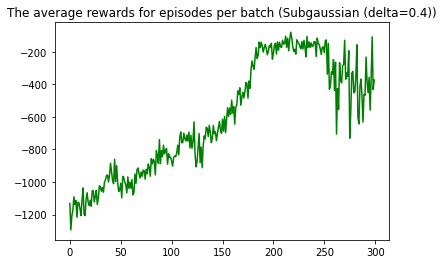

In [15]:
plt.plot(avg_ep_rews_log_04, color='green')
plt.title("The average rewards for episodes per batch (Subgaussian (delta=0.4))")
plt.show()

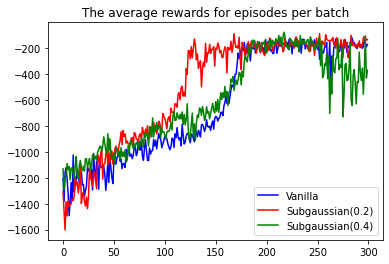

In [18]:
line0, = plt.plot(avg_ep_rews_log, color = 'blue')
line1, = plt.plot(avg_ep_rews_log_02, color = 'red')
line2, = plt.plot(avg_ep_rews_log_04, color = 'green')
plt.legend(handles = [line0, line1, line2], labels =['Vanilla', 'Subgaussian(0.2)','Subgaussian(0.4)'], loc='lower right')
plt.title("The average rewards for episodes per batch")
plt.show()

Test----

In [9]:
env = gym.make('Pendulum-v0')
fix(env, seed)
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.shape[0]

model = PPO(network=FeedForwardNN, obs_dim = obs_dim, act_dim = act_dim)
model.actor.load_checkpoint()
model.critic.load_checkpoint()
model.actor.eval()  # turn network to evaluation mode
model.critic.eval()
NUM_OF_TEST = 5 # Do not revise it !!!!!
test_total_reward = []
action_list = []
for i in range(NUM_OF_TEST):
    actions = []
    obs = env.reset()

  #img = plt.imshow(env.render(mode='rgb_array'))
    env.render()
  
    total_reward = 0

    done = False
    while not done:
        action, _ = model.get_action(obs)
        actions.append(action)
        obs, reward, done, _ = env.step(action)

        total_reward += reward

      #img.set_data(env.render(mode='rgb_array'))
        env.render()
      #display.display(plt.gcf())
      #display.clear_output(wait=True)
    print(total_reward)
    test_total_reward.append(total_reward)


env.close()

print(f"Your final reward is : %.2f"%np.mean(test_total_reward))

-120.21181737412071
-125.41116676883169
-243.96041123861386
-338.05871844153194
-242.14872698933092
Your final reward is : -213.96
